
=== Running test config: Req20_Veh4_Reg0.1 ===


C:\Users\Laxad\anaconda3\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(
C:\Users\Laxad\AppData\Local\Temp\ipykernel_28700\1792075540.py:267: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  edge_attrs = ox.utils_graph.get_route_edge_attributes(G, route)



=== Running test config: Req30_Veh6_Reg0.2 ===


C:\Users\Laxad\anaconda3\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(
C:\Users\Laxad\AppData\Local\Temp\ipykernel_28700\1792075540.py:267: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  edge_attrs = ox.utils_graph.get_route_edge_attributes(G, route)



=== Running test config: Req10_Veh2_Reg0.05 ===


C:\Users\Laxad\anaconda3\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(
C:\Users\Laxad\AppData\Local\Temp\ipykernel_28700\1792075540.py:267: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  edge_attrs = ox.utils_graph.get_route_edge_attributes(G, route)



--- Raw Results (All Configurations) ---
               Config  NumRequests  NumVehicles  RegionSize  distance_miles  \
0   Req20_Veh4_Reg0.1           20            4        0.10          86.448   
1   Req30_Veh6_Reg0.2           30            6        0.20         183.489   
2  Req10_Veh2_Reg0.05           10            2        0.05          31.607   

   sim_time_min  
0       172.896  
1       366.978  
2        63.214  


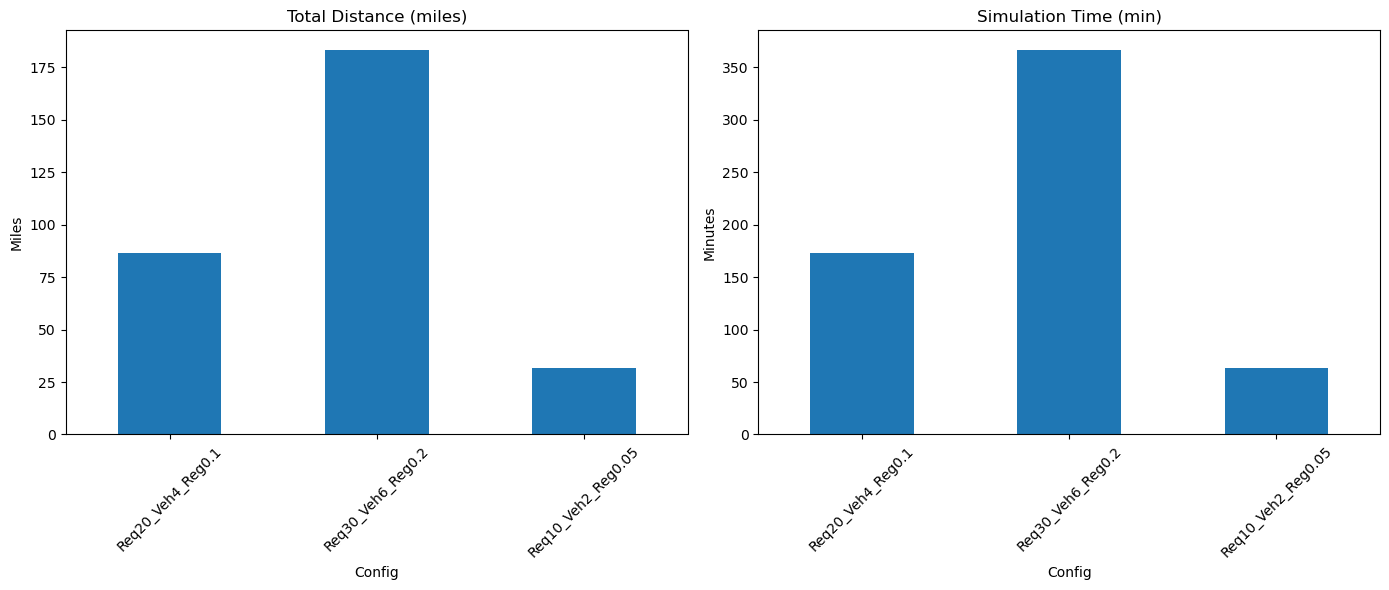

Basic grouped bar chart saved to grouped_comparison.png
Results page saved to results.html


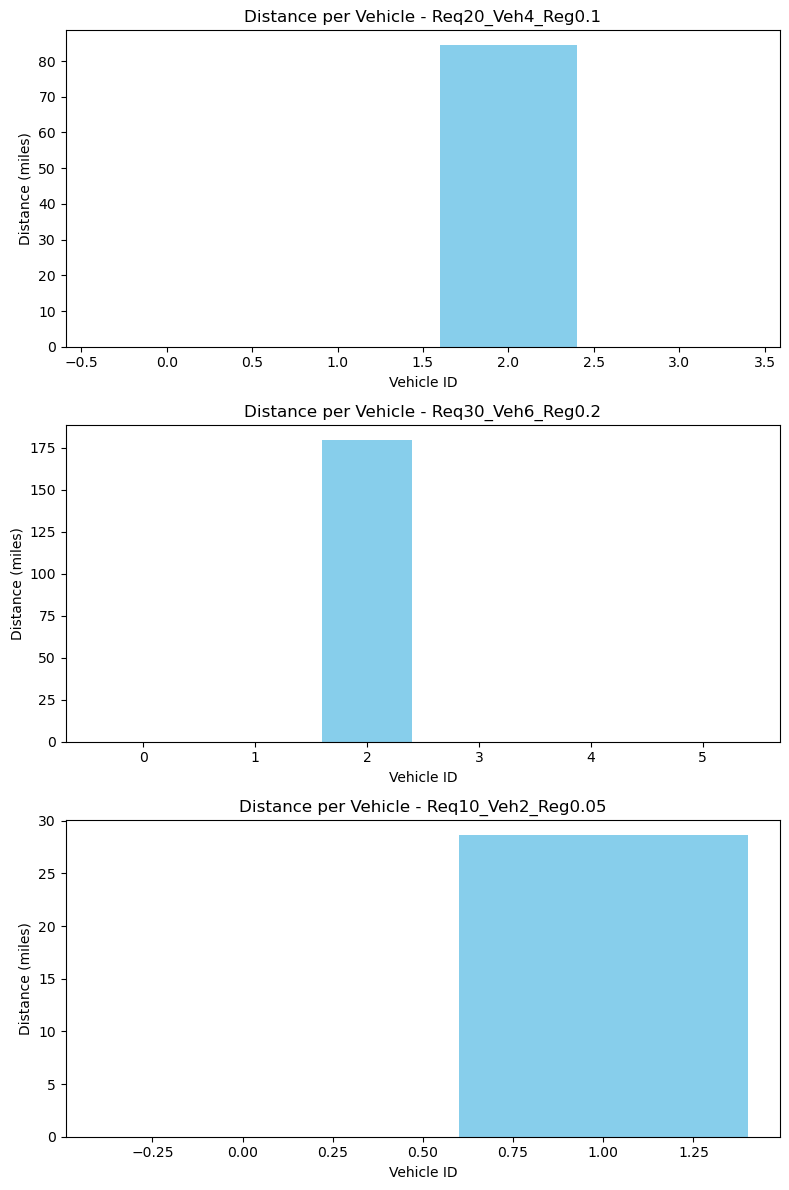

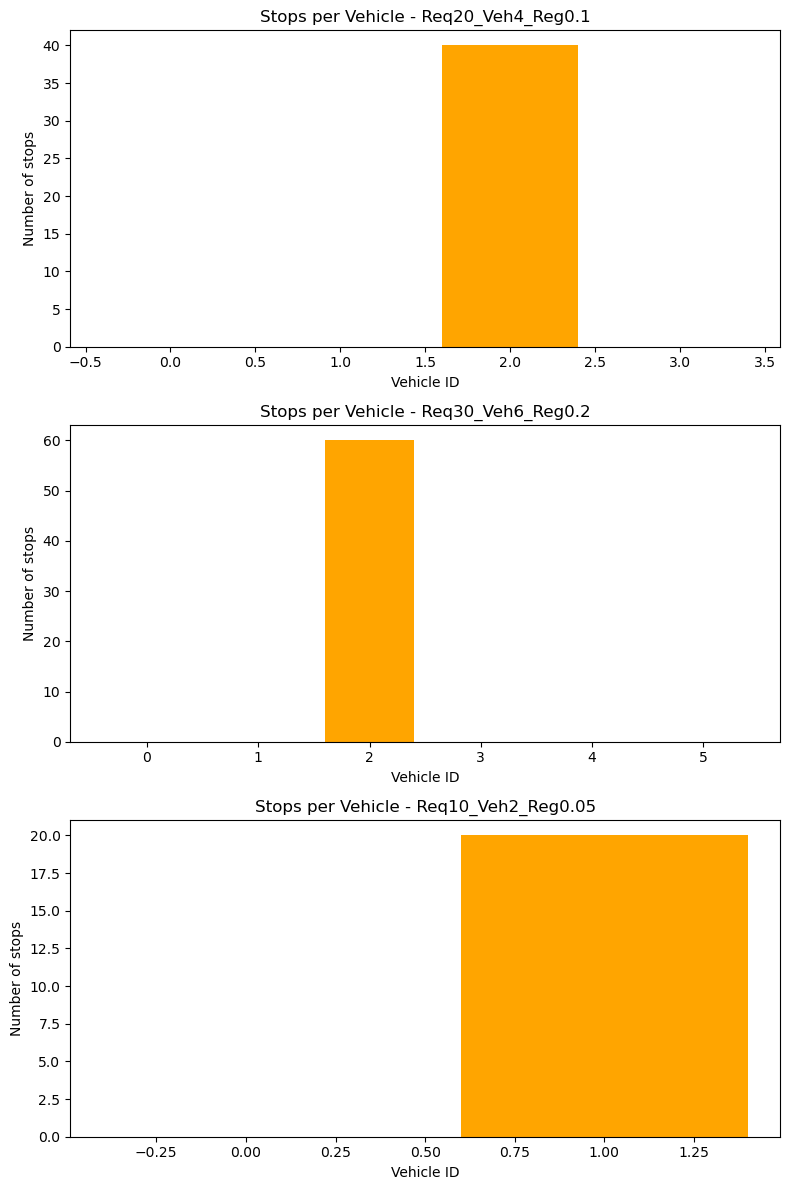

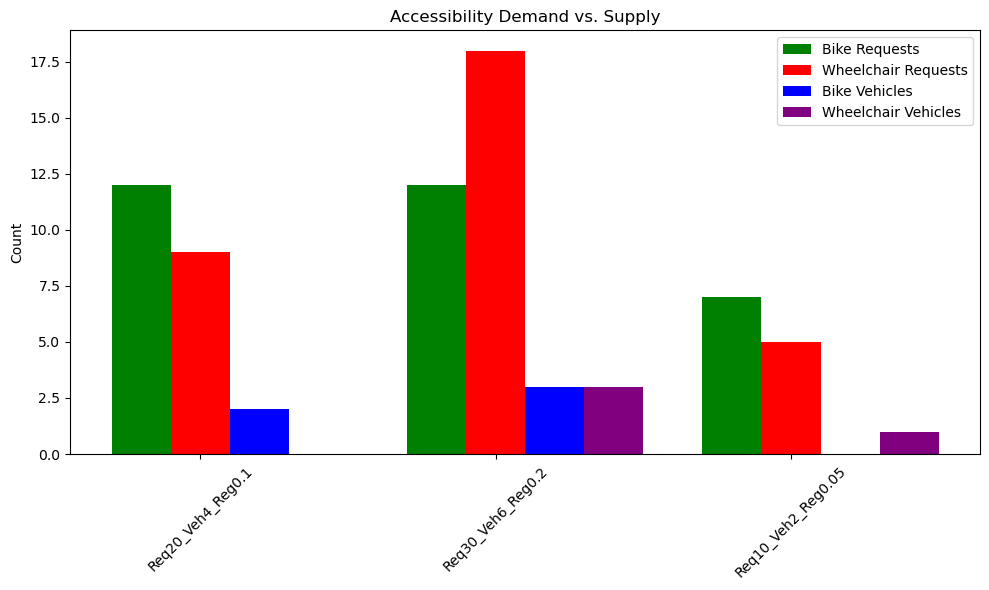

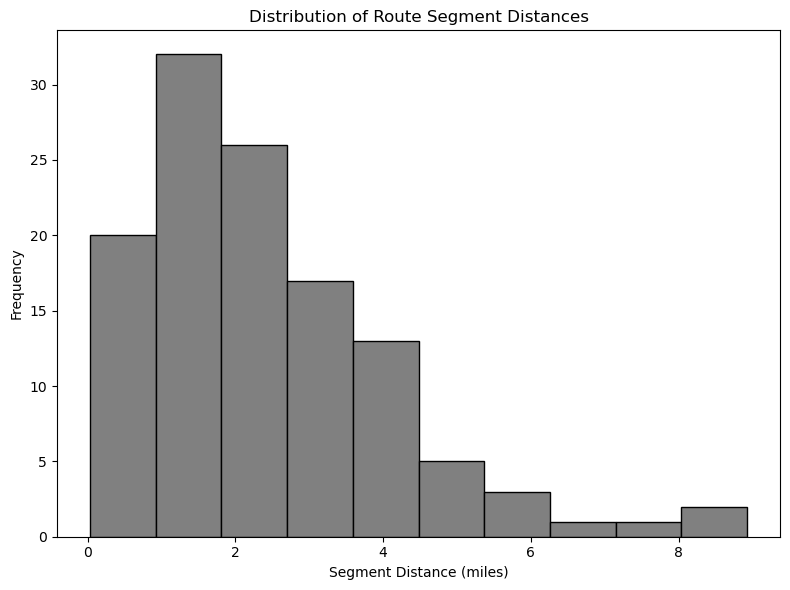

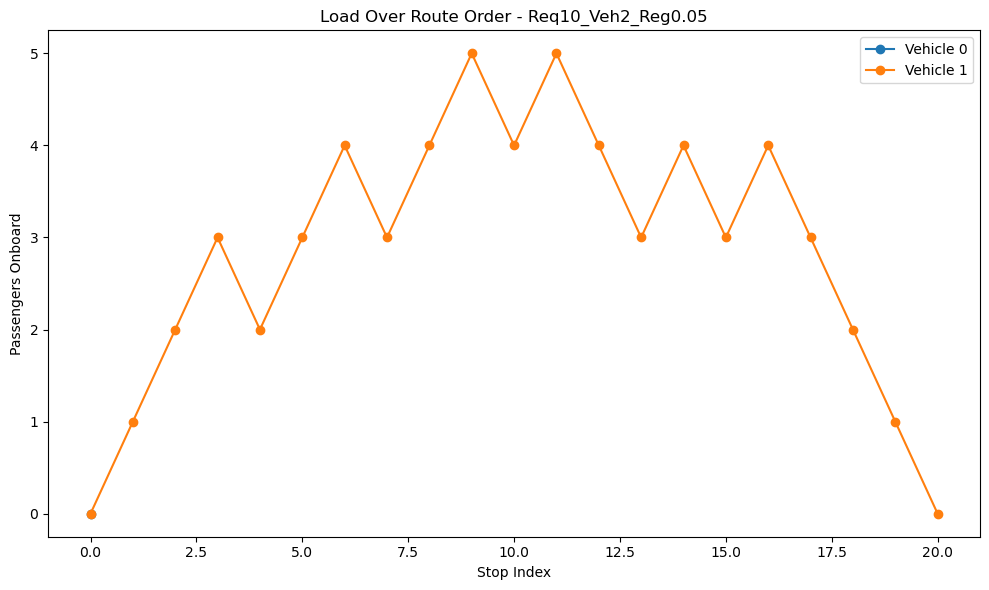

In [1]:
import sys
import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os

# Use perf_counter for high-resolution timing
from time import perf_counter

from ortools.constraint_solver import routing_enums_pb2, pywrapcp
from haversine import haversine, Unit
import folium
import osmnx as ox
import networkx as nx

# For Jupyter display if needed
IN_JUPYTER = 'ipykernel' in sys.modules
if IN_JUPYTER:
    from IPython.display import display

# -----------------------------------
# CONFIGURATION
# -----------------------------------
# Using two or three distinct case studies for easier comparison
TEST_CONFIGS = [
    {"num_requests": 20, "num_vehicles": 4, "region_size": 0.1},
    {"num_requests": 30, "num_vehicles": 6, "region_size": 0.2},
    {"num_requests": 10, "num_vehicles": 2, "region_size": 0.05}
]
TIME_LIMIT_SEC = 30  # Increase if needed

# --------------------------------------------------
# CREATE DATA
# --------------------------------------------------
def create_rural_data(num_requests=8, num_vehicles=3, region_size=0.1):
    """
    Generates a dial-a-ride problem with wide time windows and large capacities.
    Each simulation is randomly generated. Vehicle accessibility is assigned
    with a 50% probability.
    """
    import numpy as np
    center_lat, center_lon = 30.1897, -82.6393
    lat_range = region_size
    lon_range = region_size

    locations = [("Depot", center_lat, center_lon)]
    requests = []
    accessibility_requirements = {}

    for i in range(num_requests):
        pickup_lat = center_lat + random.uniform(-lat_range, lat_range)
        pickup_lon = center_lon + random.uniform(-lon_range, lon_range)
        dropoff_lat = center_lat + random.uniform(-lat_range, lat_range)
        dropoff_lon = center_lon + random.uniform(-lon_range, lon_range)
        window = (0, 1440)  # Full-day time window

        needs_bike = random.random() < 0.5
        needs_wheelchair = random.random() < 0.5
        
        req = {
            "name": f"R{i+1}",
            "pickup_lat": pickup_lat,
            "pickup_lon": pickup_lon,
            "dropoff_lat": dropoff_lat,
            "dropoff_lon": dropoff_lon,
            "time_window": window,
            "needs_bike": needs_bike,
            "needs_wheelchair": needs_wheelchair
        }
        requests.append(req)
    
    # Build location list and map pickup nodes to accessibility requirements.
    for i, req in enumerate(requests):
        locations.append((f"{req['name']}_pickup", req["pickup_lat"], req["pickup_lon"]))
        locations.append((f"{req['name']}_dropoff", req["dropoff_lat"], req["dropoff_lon"]))
        accessibility_requirements[1 + 2*i] = (req["needs_bike"], req["needs_wheelchair"])
    
    data = {}
    data["num_vehicles"] = num_vehicles
    data["depot"] = 0
    data["vehicle_capacities"] = [9999] * num_vehicles  # Large capacities

    num_locs = len(locations)
    dist_mat = np.zeros((num_locs, num_locs))
    for i in range(num_locs):
        for j in range(num_locs):
            coord1 = (locations[i][1], locations[i][2])
            coord2 = (locations[j][1], locations[j][2])
            dist_mat[i][j] = haversine(coord1, coord2, unit=Unit.MILES)
    
    data["distance_matrix"] = (dist_mat * 1000).astype(int).tolist()
    time_mat = (dist_mat / 30.0) * 60.0  # 30 mph travel assumption
    data["time_matrix"] = (time_mat * 1000).astype(int).tolist()
    
    data["demands"] = [0] * num_locs
    data["pickups_deliveries"] = []
    data["time_windows"] = []
    
    data["time_windows"].append((0, 1440))  # Depot time window
    passenger_node_to_name = {}
    for i, req in enumerate(requests):
        pu_idx = 1 + 2*i
        do_idx = pu_idx + 1
        data["pickups_deliveries"].append([pu_idx, do_idx])
        data["demands"][pu_idx] = 1
        data["demands"][do_idx] = -1
        passenger_node_to_name[pu_idx] = req["name"]
        passenger_node_to_name[do_idx] = req["name"]
        data["time_windows"].append(req["time_window"])
        data["time_windows"].append(req["time_window"])
    
    # Random vehicle accessibility with 50% chance
    data["vehicles"] = []
    for v in range(num_vehicles):
        bike_capable = random.random() < 0.5
        wheelchair_accessible = random.random() < 0.5
        data["vehicles"].append({
            "bike_capable": bike_capable,
            "wheelchair_accessible": wheelchair_accessible
        })
    
    return data, locations, passenger_node_to_name, accessibility_requirements, requests

# --------------------------------------------------
# SOLVE ROUTING
# --------------------------------------------------
def solve_routing(data, locations, passenger_node_to_name, accessibility_requirements,
                  fs_strategy="PCA", ls_heuristic="GLS", time_limit=60):
    """
    Sets up and solves the routing problem. No skipping is allowed.
    Returns:
      metrics: Dictionary of overall metrics and per-vehicle details.
      routes: List of routes (each route is a list of node indices).
    """
    manager = pywrapcp.RoutingIndexManager(len(data["distance_matrix"]),
                                           data["num_vehicles"],
                                           data["depot"])
    routing = pywrapcp.RoutingModel(manager)
    
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]
    dist_cb_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(dist_cb_idx)
    
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]
    demand_cb_idx = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(demand_cb_idx, 0,
                                            data["vehicle_capacities"],
                                            True, "Capacity")
    
    def time_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["time_matrix"][from_node][to_node]
    time_cb_idx = routing.RegisterTransitCallback(time_callback)
    routing.AddDimension(time_cb_idx, 30000, 24 * 60 * 60 * 1000, False, "Time")
    time_dim = routing.GetDimensionOrDie("Time")
    
    for loc_idx, tw in enumerate(data["time_windows"]):
        idx = manager.NodeToIndex(loc_idx)
        time_dim.CumulVar(idx).SetRange(tw[0]*60000, tw[1]*60000)
    
    for (pu_idx, do_idx) in data["pickups_deliveries"]:
        pu = manager.NodeToIndex(pu_idx)
        do = manager.NodeToIndex(do_idx)
        routing.AddPickupAndDelivery(pu, do)
        routing.solver().Add(routing.VehicleVar(pu) == routing.VehicleVar(do))
        routing.solver().Add(time_dim.CumulVar(pu) <= time_dim.CumulVar(do))
    
    for pu_idx, (needs_bike, needs_wheelchair) in accessibility_requirements.items():
        allowed_vehicles = []
        for v, vehicle in enumerate(data["vehicles"]):
            if needs_bike and not vehicle["bike_capable"]:
                continue
            if needs_wheelchair and not vehicle["wheelchair_accessible"]:
                continue
            allowed_vehicles.append(v)
        if allowed_vehicles:
            routing.SetAllowedVehiclesForIndex(allowed_vehicles, manager.NodeToIndex(pu_idx))
    
    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_params.time_limit.FromSeconds(time_limit)
    search_params.log_search = True
    
    solution = routing.SolveWithParameters(search_params)
    if not solution:
        print("No solution found!")
        return None, None
    
    routes = []
    for v in range(data["num_vehicles"]):
        index = routing.Start(v)
        route_nodes = []
        while not routing.IsEnd(index):
            node_idx = manager.IndexToNode(index)
            route_nodes.append(node_idx)
            index = solution.Value(routing.NextVar(index))
        routes.append(route_nodes)
    
    total_dist_miles = solution.ObjectiveValue() / 1000.0
    sim_time_min = (total_dist_miles / 30.0) * 60.0
    
    vehicle_details = []
    route_segment_distances = []
    for v, route in enumerate(routes):
        route_dist = 0.0
        non_depot_stops = 0
        load_over_route = []
        current_load = 0
        for i in range(len(route) - 1):
            from_node = route[i]
            to_node = route[i+1]
            dist_leg = data["distance_matrix"][from_node][to_node] / 1000.0
            route_dist += dist_leg
            route_segment_distances.append(dist_leg)
            current_load += data["demands"][from_node]
            load_over_route.append(current_load)
            if from_node != data["depot"]:
                non_depot_stops += 1
        if route:
            last_node = route[-1]
            current_load += data["demands"][last_node]
            load_over_route.append(current_load)
            if last_node != data["depot"]:
                non_depot_stops += 1
        vehicle_details.append({
            "vehicle_id": v,
            "route_distance": route_dist,
            "stops": non_depot_stops,
            "load_list": load_over_route
        })
    
    bike_requests = sum(1 for (b, w) in accessibility_requirements.values() if b)
    wheelchair_requests = sum(1 for (b, w) in accessibility_requirements.values() if w)
    bike_vehicles = sum(1 for v in data["vehicles"] if v["bike_capable"])
    wheelchair_vehicles = sum(1 for v in data["vehicles"] if v["wheelchair_accessible"])
    
    metrics = {
        "distance_miles": total_dist_miles,
        "sim_time_min": sim_time_min,
        "vehicle_details": vehicle_details,
        "segment_distances": route_segment_distances,
        "bike_requests": bike_requests,
        "wheelchair_requests": wheelchair_requests,
        "bike_vehicles": bike_vehicles,
        "wheelchair_vehicles": wheelchair_vehicles
    }
    return metrics, routes

# --------------------------------------------------
# HELPER: Get Turn-by-Turn Directions from a Route
# --------------------------------------------------
def get_directions(G, route):
    """
    Given an OSMnx graph G and a route (list of node IDs),
    returns a list of step-by-step directions using edge attributes.
    """
    directions = []
    try:
        edge_attrs = ox.utils_graph.get_route_edge_attributes(G, route)
        for attr in edge_attrs:
            road_name = attr.get('name', 'Unnamed Road')
            length_miles = attr.get('length', 0) / 1609.34  # convert meters to miles
            directions.append(f"Proceed on {road_name} for {length_miles:.2f} miles.")
    except Exception as e:
        directions.append("Error generating directions.")
    return directions

# --------------------------------------------------
# VISUALIZATION
# --------------------------------------------------
def visualize_routes(routes, data, locations, passenger_node_to_name,
                     accessibility_requirements, vehicle_colors):
    """
    Creates a Folium map with always-visible labels (DivIcon) and attaches
    turn-by-turn directions for each route (computed using OSMnx).
    Returns the map for inline display.
    """
    from folium.features import DivIcon

    depot_lat, depot_lon = locations[0][1], locations[0][2]
    m = folium.Map(location=[depot_lat, depot_lon], zoom_start=10)

    # Get an OSMnx graph for routing directions
    try:
        G = ox.graph_from_point((depot_lat, depot_lon), dist=30000, network_type='drive')
        G = G.to_undirected()
    except Exception as e:
        print("OSMnx error, using direct coordinates.", e)
        G = None

    for v_idx, route in enumerate(routes):
        color = vehicle_colors[v_idx % len(vehicle_colors)]
        coords = [(locations[node_idx][1], locations[node_idx][2]) for node_idx in route]
        folium.PolyLine(coords, color=color, weight=3).add_to(m)
        
        # If we have a graph, compute directions for the entire route
        directions_html = ""
        if G is not None and len(route) > 1:
            directions = get_directions(G, route)
            # Create a bullet list in HTML
            directions_html = "<br>".join(f"&#8226; {d}" for d in directions)
        
        # Add a marker at the start of the route with directions popup
        start_lat, start_lon = locations[route[0]][1], locations[route[0]][2]
        folium.Marker(
            location=(start_lat, start_lon),
            icon=DivIcon(
                icon_size=(250, 36),
                icon_anchor=(0, 0),
                html=f"""
                <div style="font-size: 10pt; 
                            color: white; 
                            background-color: {color}; 
                            opacity: 0.8;
                            border: 1px solid black; 
                            border-radius: 4px;
                            padding: 2px;">
                    Bus #{v_idx} Start<br>
                    Directions:<br>{directions_html}
                </div>
                """
            )
        ).add_to(m)
        
        # Label each stop with a DivIcon
        for stop_order, node_idx in enumerate(route, start=1):
            lat, lon = locations[node_idx][1], locations[node_idx][2]
            dem = data["demands"][node_idx]
            if dem == 1:
                point_type = "Pickup"
                request_name = passenger_node_to_name.get(node_idx, "?")
            elif dem == -1:
                point_type = "Dropoff"
                request_name = passenger_node_to_name.get(node_idx, "?")
            else:
                point_type = "Depot"
                request_name = "Depot"
            
            # Check accessibility for pickups
            needs_bike, needs_wheelchair = accessibility_requirements.get(node_idx, (False, False))
            icon_str = ""
            if needs_bike:
                icon_str += " 🚲"
            if needs_wheelchair:
                icon_str += " ♿"
            
            label_text = f"Bus #{v_idx}, Stop #{stop_order}, {point_type} {request_name}{icon_str}"
            offset_lat = 0.00005
            offset_lon = 0.00005
            folium.map.Marker(
                location=(lat + offset_lat, lon + offset_lon),
                icon=DivIcon(
                    icon_size=(250, 36),
                    icon_anchor=(0, 0),
                    html=f"""
                    <div style="font-size: 10pt; 
                                color: white; 
                                background-color: {color}; 
                                opacity: 0.8;
                                border: 1px solid black; 
                                border-radius: 4px;
                                width: 120px;
                                padding: 2px;">
                        {label_text}
                    </div>
                    """
                )
            ).add_to(m)
    
    return m

# --------------------------------------------------
# BUILD RESULTS PAGE
# --------------------------------------------------
def build_results_page(df, map_files, chart_file):
    html = "<html><head><title>Routing Results</title></head><body>"
    html += "<h1>Routing Test Results</h1>"
    html += "<h2>Aggregated Metrics</h2>"
    html += df.to_html(index=False)
    html += f"<h2>Comparison Chart (Basic)</h2><img src='{chart_file}' alt='Grouped Bar Chart'>"
    html += "<h2>Route Maps</h2><ul>"
    for cfg, mapfile in map_files.items():
        html += f"<li><a href='{mapfile}' target='_blank'>Config: {cfg}</a></li>"
    html += "</ul></body></html>"
    with open("results.html", "w") as f:
        f.write(html)
    print("Results page saved to results.html")

# --------------------------------------------------
# EXTRA ANALYSIS & PLOTTING
# --------------------------------------------------
def analyze_and_plot(all_runs_data):
    """
    Creates additional charts to illustrate:
      - Distance per vehicle
      - Stops per vehicle
      - Accessibility demand vs. supply
      - Distribution of route segment distances
      - Load over route order
      - Scatter of pickup/dropoff locations
    """
    import numpy as np
    
    scenario_labels = []
    all_vehicle_distances = []
    all_vehicle_stops = []
    bike_requests_list = []
    wheelchair_requests_list = []
    bike_vehicles_list = []
    wheelchair_vehicles_list = []
    all_segment_dists = []
    load_charts_data = None
    load_charts_label = None
    
    for scenario_data in all_runs_data:
        scenario_label = scenario_data["Config"]
        scenario_labels.append(scenario_label)
        v_dists = [v["route_distance"] for v in scenario_data["vehicle_details"]]
        v_stops = [v["stops"] for v in scenario_data["vehicle_details"]]
        all_vehicle_distances.append(v_dists)
        all_vehicle_stops.append(v_stops)
        bike_requests_list.append(scenario_data["bike_requests"])
        wheelchair_requests_list.append(scenario_data["wheelchair_requests"])
        bike_vehicles_list.append(scenario_data["bike_vehicles"])
        wheelchair_vehicles_list.append(scenario_data["wheelchair_vehicles"])
        all_segment_dists.extend(scenario_data["segment_distances"])
        load_charts_data = scenario_data["vehicle_details"]
        load_charts_label = scenario_label
    
    # Chart 1: Distance per Vehicle by Scenario
    fig1, axes1 = plt.subplots(len(scenario_labels), 1, figsize=(8, 4 * len(scenario_labels)))
    if len(scenario_labels) == 1:
        axes1 = [axes1]
    for idx, label in enumerate(scenario_labels):
        ax = axes1[idx]
        ax.bar(range(len(all_vehicle_distances[idx])), all_vehicle_distances[idx], color='skyblue')
        ax.set_title(f"Distance per Vehicle - {label}")
        ax.set_xlabel("Vehicle ID")
        ax.set_ylabel("Distance (miles)")
    plt.tight_layout()
    plt.savefig("distance_per_vehicle.png")
    plt.show()
    
    # Chart 2: Stops per Vehicle by Scenario
    fig2, axes2 = plt.subplots(len(scenario_labels), 1, figsize=(8, 4 * len(scenario_labels)))
    if len(scenario_labels) == 1:
        axes2 = [axes2]
    for idx, label in enumerate(scenario_labels):
        ax = axes2[idx]
        ax.bar(range(len(all_vehicle_stops[idx])), all_vehicle_stops[idx], color='orange')
        ax.set_title(f"Stops per Vehicle - {label}")
        ax.set_xlabel("Vehicle ID")
        ax.set_ylabel("Number of stops")
    plt.tight_layout()
    plt.savefig("stops_per_vehicle.png")
    plt.show()
    
    # Chart 3: Accessibility Demand vs. Supply
    x = range(len(scenario_labels))
    width = 0.2
    fig3, ax3 = plt.subplots(figsize=(10, 6))
    ax3.bar([xi - width for xi in x], bike_requests_list, width=width, label="Bike Requests", color='green')
    ax3.bar(x, wheelchair_requests_list, width=width, label="Wheelchair Requests", color='red')
    ax3.bar([xi + width for xi in x], bike_vehicles_list, width=width, label="Bike Vehicles", color='blue')
    ax3.bar([xi + 2*width for xi in x], wheelchair_vehicles_list, width=width, label="Wheelchair Vehicles", color='purple')
    ax3.set_xticks(x)
    ax3.set_xticklabels(scenario_labels, rotation=45)
    ax3.set_ylabel("Count")
    ax3.set_title("Accessibility Demand vs. Supply")
    ax3.legend()
    plt.tight_layout()
    plt.savefig("accessibility_demand_vs_supply.png")
    plt.show()
    
    # Chart 4: Distribution of Route Segment Distances (Histogram)
    fig4, ax4 = plt.subplots(figsize=(8, 6))
    ax4.hist(all_segment_dists, bins=10, color='gray', edgecolor='black')
    ax4.set_title("Distribution of Route Segment Distances")
    ax4.set_xlabel("Segment Distance (miles)")
    ax4.set_ylabel("Frequency")
    plt.tight_layout()
    plt.savefig("segment_distance_hist.png")
    plt.show()
    
    # Chart 5: Load Over Route Order
    if load_charts_data is not None:
        fig5, ax5 = plt.subplots(figsize=(10, 6))
        for vinfo in load_charts_data:
            ax5.plot(range(len(vinfo["load_list"])), vinfo["load_list"], marker='o', label=f"Vehicle {vinfo['vehicle_id']}")
        ax5.set_title(f"Load Over Route Order - {load_charts_label}")
        ax5.set_xlabel("Stop Index")
        ax5.set_ylabel("Passengers Onboard")
        ax5.legend()
        plt.tight_layout()
        plt.savefig("load_over_route.png")
        plt.show()

# --------------------------------------------------
# MAIN
# --------------------------------------------------
def main():
    all_runs = []
    map_files = {}
    
    for config in TEST_CONFIGS:
        num_requests = config["num_requests"]
        num_vehicles = config["num_vehicles"]
        region_size = config["region_size"]
        config_label = f"Req{num_requests}_Veh{num_vehicles}_Reg{region_size}"
        print(f"\n=== Running test config: {config_label} ===")
        
        data, locations, passenger_node_to_name, accessibility_requirements, requests = \
            create_rural_data(num_requests=num_requests,
                              num_vehicles=num_vehicles,
                              region_size=region_size)
        
        metrics, routes = solve_routing(data, locations, passenger_node_to_name,
                                        accessibility_requirements,
                                        fs_strategy="PCA", ls_heuristic="GLS",
                                        time_limit=TIME_LIMIT_SEC)
        if metrics is None:
            continue
        
        metrics.update({
            "Config": config_label,
            "NumRequests": num_requests,
            "NumVehicles": num_vehicles,
            "RegionSize": region_size,
            "requests": requests
        })
        all_runs.append(metrics)
        
        ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        mapfile = f"routes_{config_label}_{ts}.html"
        vehicle_colors = ['red', 'blue', 'green', 'purple', 'orange']
        my_map = visualize_routes(routes, data, locations, passenger_node_to_name,
                                  accessibility_requirements, vehicle_colors)
        my_map.save(mapfile)
        map_files[config_label] = mapfile
        
        if IN_JUPYTER:
            display(my_map)
    
    if not all_runs:
        print("No solutions found for any configuration!")
        return
    
    df = pd.DataFrame([
        {
            "Config": r["Config"],
            "NumRequests": r["NumRequests"],
            "NumVehicles": r["NumVehicles"],
            "RegionSize": r["RegionSize"],
            "distance_miles": r["distance_miles"],
            "sim_time_min": r["sim_time_min"]
        } for r in all_runs
    ])
    
    print("\n--- Raw Results (All Configurations) ---")
    print(df)
    
    df_indexed = df.set_index("Config")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    df_indexed["distance_miles"].plot(kind="bar", ax=axes[0], rot=45, width=0.5)
    axes[0].set_title("Total Distance (miles)")
    axes[0].set_ylabel("Miles")
    
    df_indexed["sim_time_min"].plot(kind="bar", ax=axes[1], rot=45, width=0.5)
    axes[1].set_title("Simulation Time (min)")
    axes[1].set_ylabel("Minutes")
    
    plt.tight_layout()
    chart_filename = "grouped_comparison.png"
    plt.savefig(chart_filename)
    plt.show()
    print(f"Basic grouped bar chart saved to {chart_filename}")
    
    build_results_page(df, map_files, chart_filename)
    analyze_and_plot(all_runs)

if __name__ == "__main__":
    main()



=== Running test config: Req10_Veh2_Reg0.05 ===


C:\Users\Laxad\anaconda3\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(



=== Running test config: Req20_Veh4_Reg0.1 ===


C:\Users\Laxad\anaconda3\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(



=== Running test config: Req30_Veh6_Reg0.2 ===


C:\Users\Laxad\anaconda3\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(



--- Raw Results (All Configurations) ---
               Config  NumRequests  NumVehicles  RegionSize  distance_miles  \
0  Req10_Veh2_Reg0.05           10            2        0.05          29.535   
1   Req20_Veh4_Reg0.1           20            4        0.10          79.009   
2   Req30_Veh6_Reg0.2           30            6        0.20         199.748   

   sim_time_min  
0        59.070  
1       158.018  
2       399.496  


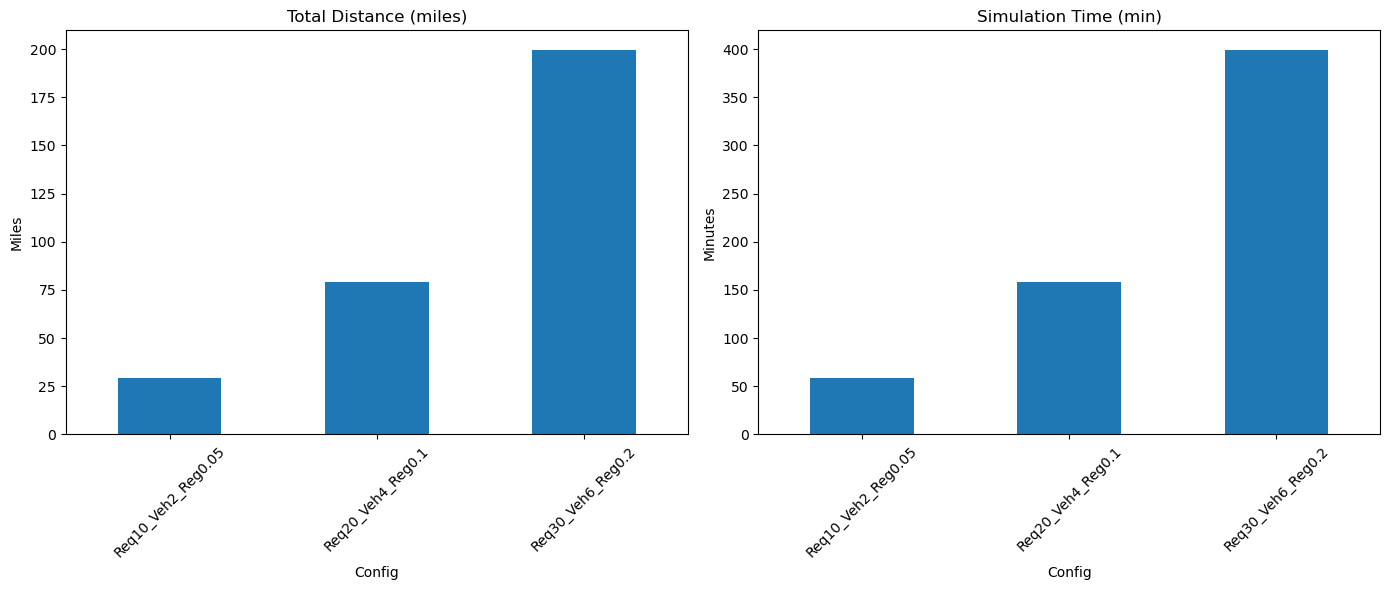

Basic grouped bar chart saved to grouped_comparison.png
Results page saved to results.html


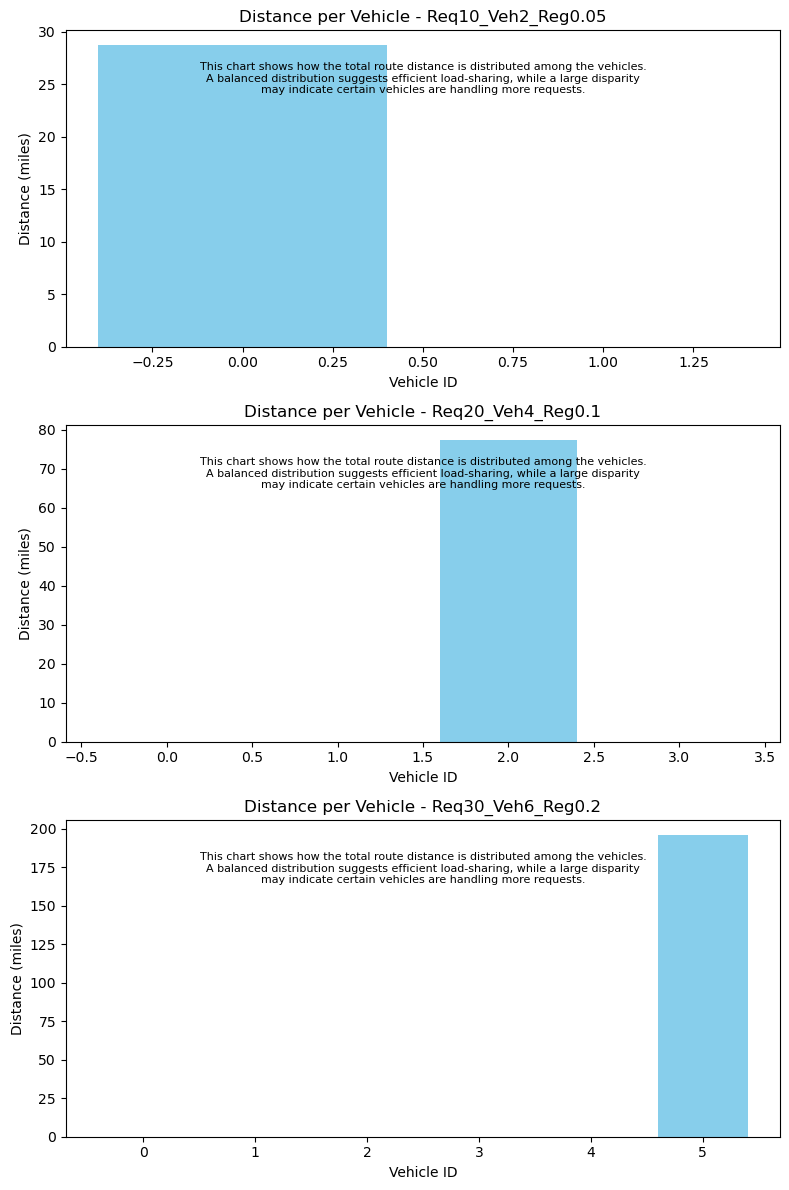

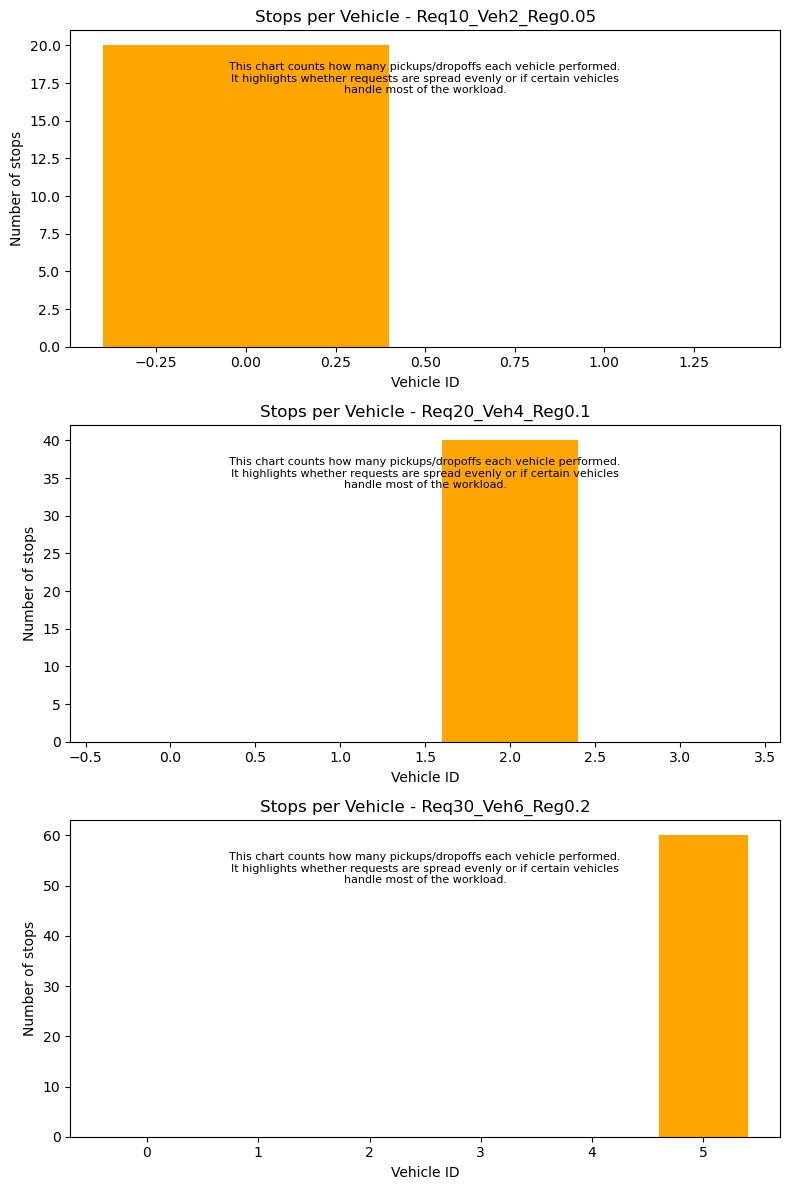

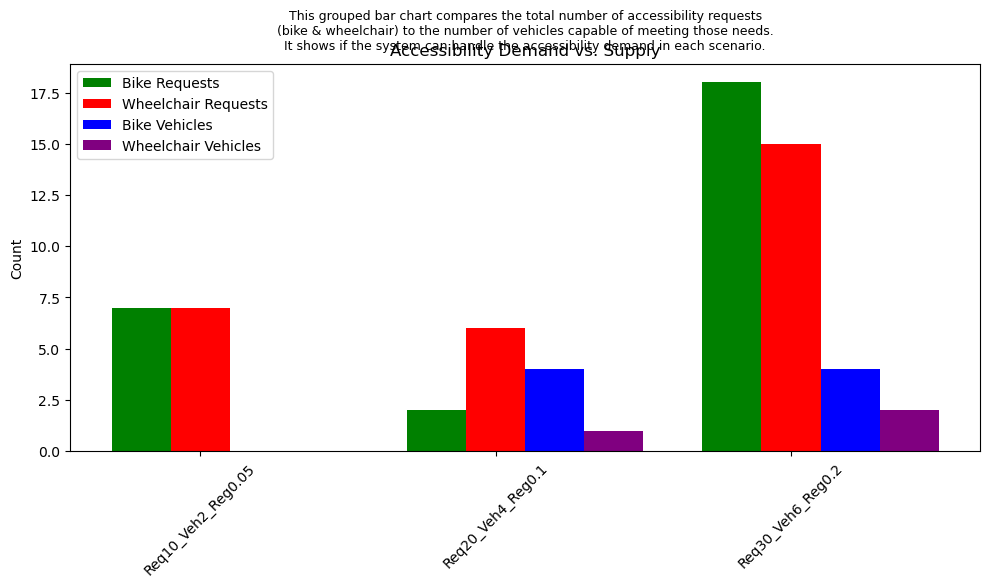

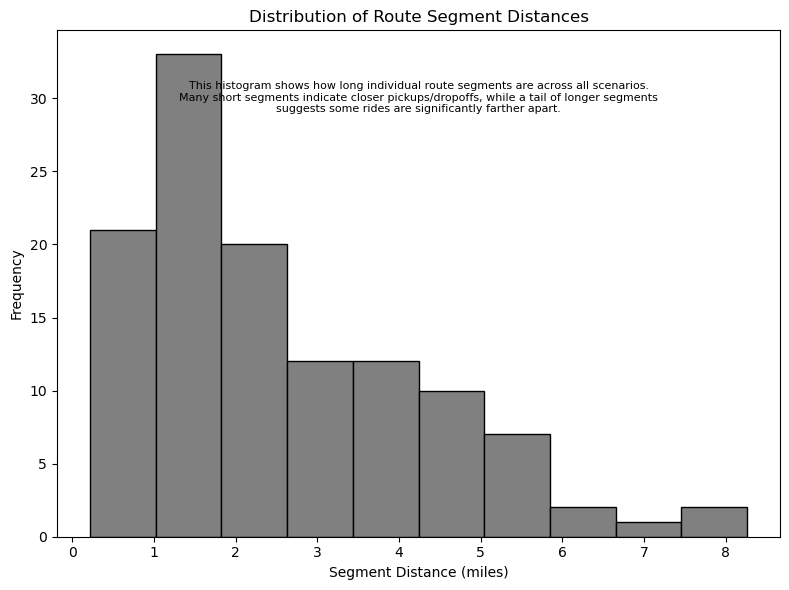

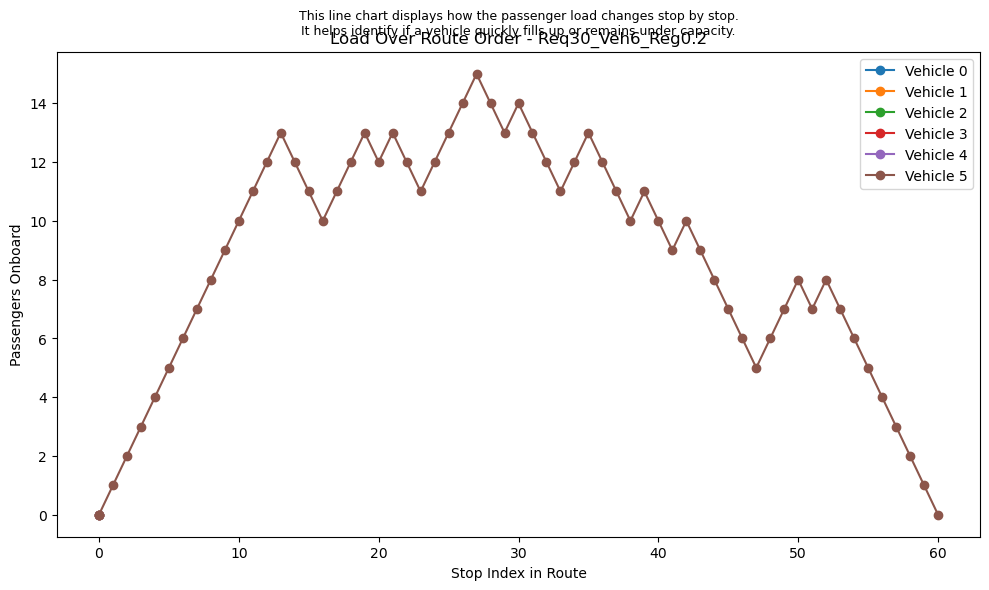

In [3]:
import sys
import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os

# Use perf_counter for high-resolution timing
from time import perf_counter

from ortools.constraint_solver import routing_enums_pb2, pywrapcp
from haversine import haversine, Unit
import folium
import osmnx as ox
import networkx as nx

# For Jupyter display if needed
IN_JUPYTER = 'ipykernel' in sys.modules
if IN_JUPYTER:
    from IPython.display import display

###############################################################################
# 1) SCENARIO DEFINITIONS (Case Studies)
###############################################################################
# We define three scenarios to reflect small, medium, and large region demands.
# Each scenario can be repeated or slightly changed if you want multiple runs.
TEST_CONFIGS = [
    # Case Study A: small region, fewer requests
    {"num_requests": 10, "num_vehicles": 2, "region_size": 0.05},
    # Case Study B: moderate region, moderate requests
    {"num_requests": 20, "num_vehicles": 4, "region_size": 0.1},
    # Case Study C: larger region, more requests
    {"num_requests": 30, "num_vehicles": 6, "region_size": 0.2},
]
TIME_LIMIT_SEC = 30  # Increase if needed

###############################################################################
# 2) DATA CREATION (RANDOM)
###############################################################################
def create_rural_data(num_requests=8, num_vehicles=3, region_size=0.1):
    """
    Generates a dial-a-ride problem with wide time windows and large capacities.
    Randomness ensures each run is unique. We do not fix seeds here.
    """
    import numpy as np
    center_lat, center_lon = 30.1897, -82.6393
    lat_range = region_size
    lon_range = region_size

    locations = [("Depot", center_lat, center_lon)]
    requests = []
    accessibility_requirements = {}

    for i in range(num_requests):
        pickup_lat = center_lat + random.uniform(-lat_range, lat_range)
        pickup_lon = center_lon + random.uniform(-lon_range, lon_range)
        dropoff_lat = center_lat + random.uniform(-lat_range, lat_range)
        dropoff_lon = center_lon + random.uniform(-lon_range, lon_range)

        # Full-day time windows
        window = (0, 1440)

        needs_bike = (random.random() < 0.5)
        needs_wheelchair = (random.random() < 0.5)
        
        req = {
            "name": f"R{i+1}",
            "pickup_lat": pickup_lat,
            "pickup_lon": pickup_lon,
            "dropoff_lat": dropoff_lat,
            "dropoff_lon": dropoff_lon,
            "time_window": window,
            "needs_bike": needs_bike,
            "needs_wheelchair": needs_wheelchair
        }
        requests.append(req)
    
    # Build location list
    for i, req in enumerate(requests):
        # pickup
        locations.append((f"{req['name']}_pickup", req["pickup_lat"], req["pickup_lon"]))
        # dropoff
        locations.append((f"{req['name']}_dropoff", req["dropoff_lat"], req["dropoff_lon"]))
        # Store accessibility for pickup node only
        accessibility_requirements[1 + 2*i] = (req["needs_bike"], req["needs_wheelchair"])
    
    data = {}
    data["num_vehicles"] = num_vehicles
    data["depot"] = 0
    # Large capacity to avoid capacity constraints overshadowing the test
    data["vehicle_capacities"] = [9999] * num_vehicles

    num_locs = len(locations)
    dist_mat = np.zeros((num_locs, num_locs))
    for i in range(num_locs):
        for j in range(num_locs):
            coord1 = (locations[i][1], locations[i][2])
            coord2 = (locations[j][1], locations[j][2])
            dist_mat[i][j] = haversine(coord1, coord2, unit=Unit.MILES)
    
    data["distance_matrix"] = (dist_mat * 1000).astype(int).tolist()
    # Time matrix based on 30 mph
    time_mat = (dist_mat / 30.0) * 60.0
    data["time_matrix"] = (time_mat * 1000).astype(int).tolist()
    
    data["demands"] = [0] * num_locs
    data["pickups_deliveries"] = []
    data["time_windows"] = []
    
    # Depot time window
    data["time_windows"].append((0, 1440))
    
    passenger_node_to_name = {}
    for i, req in enumerate(requests):
        pu_idx = 1 + 2*i
        do_idx = pu_idx + 1
        data["pickups_deliveries"].append([pu_idx, do_idx])
        data["demands"][pu_idx] = 1
        data["demands"][do_idx] = -1
        passenger_node_to_name[pu_idx] = req["name"]
        passenger_node_to_name[do_idx] = req["name"]
        data["time_windows"].append(req["time_window"])
        data["time_windows"].append(req["time_window"])
    
    # Vehicle accessibility with 50% chance each
    data["vehicles"] = []
    for v in range(num_vehicles):
        bike_capable = (random.random() < 0.5)
        wheelchair_accessible = (random.random() < 0.5)
        data["vehicles"].append({
            "bike_capable": bike_capable,
            "wheelchair_accessible": wheelchair_accessible
        })
    
    return data, locations, passenger_node_to_name, accessibility_requirements, requests

###############################################################################
# 3) SOLVE ROUTING
###############################################################################
def solve_routing(data, locations, passenger_node_to_name, accessibility_requirements,
                  fs_strategy="PCA", ls_heuristic="GLS", time_limit=60):
    """
    Solves the routing problem with no skipping. 
    Returns metrics and the route for each vehicle.
    """
    manager = pywrapcp.RoutingIndexManager(len(data["distance_matrix"]),
                                           data["num_vehicles"],
                                           data["depot"])
    routing = pywrapcp.RoutingModel(manager)
    
    def distance_callback(from_index, to_index):
        return data["distance_matrix"][manager.IndexToNode(from_index)][manager.IndexToNode(to_index)]
    dist_cb_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(dist_cb_idx)
    
    def demand_callback(from_index):
        return data["demands"][manager.IndexToNode(from_index)]
    demand_cb_idx = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(demand_cb_idx, 0,
                                            data["vehicle_capacities"],
                                            True, "Capacity")
    
    def time_callback(from_index, to_index):
        return data["time_matrix"][manager.IndexToNode(from_index)][manager.IndexToNode(to_index)]
    time_cb_idx = routing.RegisterTransitCallback(time_callback)
    routing.AddDimension(time_cb_idx, 30000, 24*60*60*1000, False, "Time")
    time_dim = routing.GetDimensionOrDie("Time")
    
    for loc_idx, tw in enumerate(data["time_windows"]):
        idx = manager.NodeToIndex(loc_idx)
        time_dim.CumulVar(idx).SetRange(tw[0]*60000, tw[1]*60000)
    
    # Pickup and Delivery
    for (pu_idx, do_idx) in data["pickups_deliveries"]:
        pu = manager.NodeToIndex(pu_idx)
        do = manager.NodeToIndex(do_idx)
        routing.AddPickupAndDelivery(pu, do)
        routing.solver().Add(routing.VehicleVar(pu) == routing.VehicleVar(do))
        routing.solver().Add(time_dim.CumulVar(pu) <= time_dim.CumulVar(do))
    
    # Accessibility constraints
    for pu_idx, (needs_bike, needs_wheelchair) in accessibility_requirements.items():
        allowed_vehicles = []
        for v, vehicle in enumerate(data["vehicles"]):
            if needs_bike and not vehicle["bike_capable"]:
                continue
            if needs_wheelchair and not vehicle["wheelchair_accessible"]:
                continue
            allowed_vehicles.append(v)
        if allowed_vehicles:
            routing.SetAllowedVehiclesForIndex(allowed_vehicles, manager.NodeToIndex(pu_idx))
    
    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_params.time_limit.FromSeconds(time_limit)
    search_params.log_search = True
    
    solution = routing.SolveWithParameters(search_params)
    if not solution:
        print("No solution found!")
        return None, None
    
    # Extract routes
    routes = []
    for v in range(data["num_vehicles"]):
        index = routing.Start(v)
        route_nodes = []
        while not routing.IsEnd(index):
            route_nodes.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        routes.append(route_nodes)
    
    # Calculate total distance
    total_dist_miles = solution.ObjectiveValue() / 1000.0
    sim_time_min = (total_dist_miles / 30.0) * 60.0
    
    # Gather vehicle details
    vehicle_details = []
    route_segment_distances = []
    for v, route in enumerate(routes):
        route_dist = 0.0
        non_depot_stops = 0
        load_over_route = []
        current_load = 0
        for i in range(len(route)-1):
            from_node = route[i]
            to_node = route[i+1]
            dist_leg = data["distance_matrix"][from_node][to_node] / 1000.0
            route_dist += dist_leg
            route_segment_distances.append(dist_leg)
            current_load += data["demands"][from_node]
            load_over_route.append(current_load)
            if from_node != data["depot"]:
                non_depot_stops += 1
        if route:
            last_node = route[-1]
            current_load += data["demands"][last_node]
            load_over_route.append(current_load)
            if last_node != data["depot"]:
                non_depot_stops += 1
        vehicle_details.append({
            "vehicle_id": v,
            "route_distance": route_dist,
            "stops": non_depot_stops,
            "load_list": load_over_route
        })
    
    bike_requests = sum(1 for (b, w) in accessibility_requirements.values() if b)
    wheelchair_requests = sum(1 for (b, w) in accessibility_requirements.values() if w)
    bike_vehicles = sum(1 for v in data["vehicles"] if v["bike_capable"])
    wheelchair_vehicles = sum(1 for v in data["vehicles"] if v["wheelchair_accessible"])
    
    metrics = {
        "distance_miles": total_dist_miles,
        "sim_time_min": sim_time_min,
        "vehicle_details": vehicle_details,
        "segment_distances": route_segment_distances,
        "bike_requests": bike_requests,
        "wheelchair_requests": wheelchair_requests,
        "bike_vehicles": bike_vehicles,
        "wheelchair_vehicles": wheelchair_vehicles
    }
    return metrics, routes

###############################################################################
# 4) VISUALIZATION (MAP)
###############################################################################
def visualize_routes(routes, data, locations, passenger_node_to_name,
                     accessibility_requirements, vehicle_colors):
    """
    Creates a Folium map with always-visible labels (DivIcon).
    """
    from folium.features import DivIcon
    depot_lat, depot_lon = locations[0][1], locations[0][2]
    m = folium.Map(location=[depot_lat, depot_lon], zoom_start=10)

    # Attempt to create an OSM graph for route directions
    try:
        G = ox.graph_from_point((depot_lat, depot_lon), dist=30000, network_type='drive')
        G = G.to_undirected()
    except Exception as e:
        print("OSMnx error, using direct coords only:", e)
        G = None

    for v_idx, route in enumerate(routes):
        color = vehicle_colors[v_idx % len(vehicle_colors)]
        coords = [(locations[node_idx][1], locations[node_idx][2]) for node_idx in route]
        folium.PolyLine(coords, color=color, weight=3).add_to(m)
        
        # Label each stop with a DivIcon
        for stop_order, node_idx in enumerate(route, start=1):
            lat, lon = locations[node_idx][1], locations[node_idx][2]
            dem = data["demands"][node_idx]
            if dem == 1:
                point_type = "Pickup"
                request_name = passenger_node_to_name.get(node_idx, "?")
            elif dem == -1:
                point_type = "Dropoff"
                request_name = passenger_node_to_name.get(node_idx, "?")
            else:
                point_type = "Depot"
                request_name = "Depot"
            
            needs_bike, needs_wheelchair = accessibility_requirements.get(node_idx, (False, False))
            icon_str = ""
            if needs_bike:
                icon_str += " 🚲"
            if needs_wheelchair:
                icon_str += " ♿"
            
            label_text = f"Bus #{v_idx}, Stop #{stop_order}, {point_type} {request_name}{icon_str}"
            offset_lat = 0.00005
            offset_lon = 0.00005
            folium.map.Marker(
                location=(lat + offset_lat, lon + offset_lon),
                icon=DivIcon(
                    icon_size=(250, 36),
                    icon_anchor=(0, 0),
                    html=f"""
                    <div style="font-size: 10pt; 
                                color: white; 
                                background-color: {color}; 
                                opacity: 0.8;
                                border: 1px solid black; 
                                border-radius: 4px;
                                padding: 2px;">
                        {label_text}
                    </div>
                    """
                )
            ).add_to(m)
    
    return m

###############################################################################
# 5) BUILD RESULTS PAGE (HTML)
###############################################################################
def build_results_page(df, map_files, chart_file):
    html = "<html><head><title>Routing Results</title></head><body>"
    html += "<h1>Routing Test Results</h1>"
    html += "<p>Below are the aggregated metrics from our three case studies, each representing a distinct scenario in terms of number of requests, vehicles, and region size.</p>"
    html += "<h2>Aggregated Metrics</h2>"
    html += df.to_html(index=False)
    html += f"<h2>Comparison Chart (Basic)</h2><p>This bar chart compares total distance (left) and simulation time (right) across the scenarios. We see how the system scales with the number of requests and region size.</p>"
    html += f"<img src='{chart_file}' alt='Grouped Bar Chart' style='max-width:800px;'>"
    html += "<h2>Route Maps</h2><ul>"
    for cfg, mapfile in map_files.items():
        html += f"<li><a href='{mapfile}' target='_blank'>Config: {cfg}</a> - View the Folium map for this scenario.</li>"
    html += "</ul></body></html>"
    with open("results.html", "w") as f:
        f.write(html)
    print("Results page saved to results.html")

###############################################################################
# 6) ANALYZE AND PLOT (CHARTS WITH DESCRIPTIONS)
###############################################################################
def analyze_and_plot(all_runs_data):
    """
    Creates charts to illustrate:
      - Distance per vehicle
      - Stops per vehicle
      - Accessibility demand vs. supply
      - Distribution of route segment distances
      - Load over route order
    Each chart is accompanied by a textual explanation.
    """
    import numpy as np
    
    scenario_labels = []
    all_vehicle_distances = []
    all_vehicle_stops = []
    bike_requests_list = []
    wheelchair_requests_list = []
    bike_vehicles_list = []
    wheelchair_vehicles_list = []
    all_segment_dists = []
    load_charts_data = None
    load_charts_label = None
    
    # Gather data from each scenario
    for scenario_data in all_runs_data:
        scenario_label = scenario_data["Config"]
        scenario_labels.append(scenario_label)
        
        v_dists = [v["route_distance"] for v in scenario_data["vehicle_details"]]
        v_stops = [v["stops"] for v in scenario_data["vehicle_details"]]
        
        all_vehicle_distances.append(v_dists)
        all_vehicle_stops.append(v_stops)
        
        bike_requests_list.append(scenario_data["bike_requests"])
        wheelchair_requests_list.append(scenario_data["wheelchair_requests"])
        bike_vehicles_list.append(scenario_data["bike_vehicles"])
        wheelchair_vehicles_list.append(scenario_data["wheelchair_vehicles"])
        
        all_segment_dists.extend(scenario_data["segment_distances"])
        
        # We'll store the last scenario's data for the "Load Over Route" chart
        load_charts_data = scenario_data["vehicle_details"]
        load_charts_label = scenario_label
    
    # 1) Distance per Vehicle by Scenario
    fig1, axes1 = plt.subplots(len(scenario_labels), 1, figsize=(8, 4 * len(scenario_labels)))
    if len(scenario_labels) == 1:
        axes1 = [axes1]
    for idx, label in enumerate(scenario_labels):
        ax = axes1[idx]
        dist_list = all_vehicle_distances[idx]
        ax.bar(range(len(dist_list)), dist_list, color='skyblue')
        ax.set_title(f"Distance per Vehicle - {label}")
        ax.set_xlabel("Vehicle ID")
        ax.set_ylabel("Distance (miles)")
        # Explanation
        ax.text(0.5, 0.9, 
                "This chart shows how the total route distance is distributed among the vehicles.\n"
                "A balanced distribution suggests efficient load-sharing, while a large disparity\n"
                "may indicate certain vehicles are handling more requests.",
                transform=ax.transAxes, fontsize=8, verticalalignment='top', horizontalalignment='center')
    plt.tight_layout()
    plt.savefig("distance_per_vehicle.png")
    plt.show()
    
    # 2) Stops per Vehicle by Scenario
    fig2, axes2 = plt.subplots(len(scenario_labels), 1, figsize=(8, 4 * len(scenario_labels)))
    if len(scenario_labels) == 1:
        axes2 = [axes2]
    for idx, label in enumerate(scenario_labels):
        ax = axes2[idx]
        stops_list = all_vehicle_stops[idx]
        ax.bar(range(len(stops_list)), stops_list, color='orange')
        ax.set_title(f"Stops per Vehicle - {label}")
        ax.set_xlabel("Vehicle ID")
        ax.set_ylabel("Number of stops")
        # Explanation
        ax.text(0.5, 0.9,
                "This chart counts how many pickups/dropoffs each vehicle performed.\n"
                "It highlights whether requests are spread evenly or if certain vehicles\n"
                "handle most of the workload.",
                transform=ax.transAxes, fontsize=8, verticalalignment='top', horizontalalignment='center')
    plt.tight_layout()
    plt.savefig("stops_per_vehicle.png")
    plt.show()
    
    # 3) Accessibility Demand vs. Supply (Grouped Bar)
    x = range(len(scenario_labels))
    width = 0.2
    fig3, ax3 = plt.subplots(figsize=(10, 6))
    ax3.bar([xi - width for xi in x], bike_requests_list, width=width, label="Bike Requests", color='green')
    ax3.bar(x, wheelchair_requests_list, width=width, label="Wheelchair Requests", color='red')
    ax3.bar([xi + width for xi in x], bike_vehicles_list, width=width, label="Bike Vehicles", color='blue')
    ax3.bar([xi + 2*width for xi in x], wheelchair_vehicles_list, width=width, label="Wheelchair Vehicles", color='purple')
    ax3.set_xticks(list(x))
    ax3.set_xticklabels(scenario_labels, rotation=45)
    ax3.set_ylabel("Count")
    ax3.set_title("Accessibility Demand vs. Supply")
    ax3.legend()
    # Explanation
    ax3.text(0.5, 1.03,
             "This grouped bar chart compares the total number of accessibility requests\n"
             "(bike & wheelchair) to the number of vehicles capable of meeting those needs.\n"
             "It shows if the system can handle the accessibility demand in each scenario.",
             transform=ax3.transAxes, fontsize=9, verticalalignment='bottom', horizontalalignment='center')
    plt.tight_layout()
    plt.savefig("accessibility_demand_vs_supply.png")
    plt.show()
    
    # 4) Distribution of Route Segment Distances (Histogram)
    fig4, ax4 = plt.subplots(figsize=(8, 6))
    ax4.hist(all_segment_dists, bins=10, color='gray', edgecolor='black')
    ax4.set_title("Distribution of Route Segment Distances")
    ax4.set_xlabel("Segment Distance (miles)")
    ax4.set_ylabel("Frequency")
    # Explanation
    ax4.text(0.5, 0.9,
             "This histogram shows how long individual route segments are across all scenarios.\n"
             "Many short segments indicate closer pickups/dropoffs, while a tail of longer segments\n"
             "suggests some rides are significantly farther apart.",
             transform=ax4.transAxes, fontsize=8, verticalalignment='top', horizontalalignment='center')
    plt.tight_layout()
    plt.savefig("segment_distance_hist.png")
    plt.show()
    
    # 5) Load Over Route Order (Line Chart) - from the last scenario
    if load_charts_data is not None:
        fig5, ax5 = plt.subplots(figsize=(10, 6))
        for vinfo in load_charts_data:
            v_id = vinfo["vehicle_id"]
            load_list = vinfo["load_list"]
            ax5.plot(range(len(load_list)), load_list, marker='o', label=f"Vehicle {v_id}")
        ax5.set_title(f"Load Over Route Order - {load_charts_label}")
        ax5.set_xlabel("Stop Index in Route")
        ax5.set_ylabel("Passengers Onboard")
        ax5.legend()
        # Explanation
        ax5.text(0.5, 1.03,
                 "This line chart displays how the passenger load changes stop by stop.\n"
                 "It helps identify if a vehicle quickly fills up or remains under capacity.",
                 transform=ax5.transAxes, fontsize=9, verticalalignment='bottom', horizontalalignment='center')
        plt.tight_layout()
        plt.savefig("load_over_route.png")
        plt.show()

###############################################################################
# 7) MAIN: RUN CASE STUDIES, PLOT, & GENERATE RESULTS
###############################################################################
def main():
    all_runs = []
    map_files = {}
    
    for config in TEST_CONFIGS:
        num_requests = config["num_requests"]
        num_vehicles = config["num_vehicles"]
        region_size = config["region_size"]
        config_label = f"Req{num_requests}_Veh{num_vehicles}_Reg{region_size}"
        print(f"\n=== Running test config: {config_label} ===")
        
        # Create random data for this scenario
        data, locations, passenger_node_to_name, accessibility_requirements, requests = \
            create_rural_data(num_requests=num_requests,
                              num_vehicles=num_vehicles,
                              region_size=region_size)
        
        # Solve routing
        metrics, routes = solve_routing(data, locations, passenger_node_to_name,
                                        accessibility_requirements,
                                        fs_strategy="PCA", ls_heuristic="GLS",
                                        time_limit=TIME_LIMIT_SEC)
        if metrics is None:
            continue
        
        # Store scenario-level info
        metrics.update({
            "Config": config_label,
            "NumRequests": num_requests,
            "NumVehicles": num_vehicles,
            "RegionSize": region_size,
            "requests": requests
        })
        all_runs.append(metrics)
        
        # Create a map for each scenario
        ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        mapfile = f"routes_{config_label}_{ts}.html"
        vehicle_colors = ['red', 'blue', 'green', 'purple', 'orange']
        my_map = visualize_routes(routes, data, locations, passenger_node_to_name,
                                  accessibility_requirements, vehicle_colors)
        my_map.save(mapfile)
        map_files[config_label] = mapfile
        
        # Display inline if in Jupyter
        if IN_JUPYTER:
            display(my_map)
    
    if not all_runs:
        print("No solutions found for any configuration!")
        return
    
    # Build a DataFrame of the main metrics for each scenario
    df = pd.DataFrame([
        {
            "Config": r["Config"],
            "NumRequests": r["NumRequests"],
            "NumVehicles": r["NumVehicles"],
            "RegionSize": r["RegionSize"],
            "distance_miles": r["distance_miles"],
            "sim_time_min": r["sim_time_min"]
        } for r in all_runs
    ])
    
    print("\n--- Raw Results (All Configurations) ---")
    print(df)
    
    # Basic bar charts for total distance & sim time
    df_indexed = df.set_index("Config")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    df_indexed["distance_miles"].plot(kind="bar", ax=axes[0], rot=45, width=0.5)
    axes[0].set_title("Total Distance (miles)")
    axes[0].set_ylabel("Miles")
    
    df_indexed["sim_time_min"].plot(kind="bar", ax=axes[1], rot=45, width=0.5)
    axes[1].set_title("Simulation Time (min)")
    axes[1].set_ylabel("Minutes")
    plt.tight_layout()
    chart_filename = "grouped_comparison.png"
    plt.savefig(chart_filename)
    plt.show()
    print(f"Basic grouped bar chart saved to {chart_filename}")
    
    # Build HTML results page
    build_results_page(df, map_files, chart_filename)
    
    # Create additional analysis & charts with textual explanations
    analyze_and_plot(all_runs)

if __name__ == "__main__":
    main()


In [ ]:
import sys
import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np # Added for array operations if needed later

# Use perf_counter for high-resolution timing
from time import perf_counter

from ortools.constraint_solver import routing_enums_pb2, pywrapcp
from haversine import haversine, Unit
import folium
# import osmnx as ox # Commented out as it wasn't used in visualize_routes and can cause install issues
# import networkx as nx # Commented out as it wasn't used

# For Jupyter display if needed
IN_JUPYTER = 'ipykernel' in sys.modules
if IN_JUPYTER:
    from IPython.display import display

###############################################################################
# 1) SCENARIO DEFINITIONS (Case Studies)
###############################################################################
# We define three scenarios to reflect small, medium, and large region demands.
# Each scenario can be repeated or slightly changed if you want multiple runs.
TEST_CONFIGS = [
    # Case Study A: small region, fewer requests
    {"num_requests": 10, "num_vehicles": 2, "region_size": 0.05},
    # Case Study B: moderate region, moderate requests
    {"num_requests": 20, "num_vehicles": 4, "region_size": 0.1},
    # Case Study C: larger region, more requests
    {"num_requests": 30, "num_vehicles": 6, "region_size": 0.2},
]
TIME_LIMIT_SEC = 30  # Increase if needed

###############################################################################
# 2) DATA CREATION (RANDOM)
###############################################################################
def create_rural_data(num_requests=8, num_vehicles=3, region_size=0.1):
    """
    Generates a dial-a-ride problem with wide time windows and large capacities.
    Randomness ensures each run is unique. We do not fix seeds here.
    """
    center_lat, center_lon = 30.1897, -82.6393 # Near Lake City, FL (rural area example)
    lat_range = region_size / 2.0 # Adjust range interpretation
    lon_range = region_size / 2.0 # Adjust range interpretation

    locations = [("Depot", center_lat, center_lon)]
    requests = []
    accessibility_requirements = {} # Maps pickup node index to (needs_bike, needs_wheelchair)

    for i in range(num_requests):
        # Ensure pickup and dropoff are reasonably separated
        pickup_lat = center_lat + random.uniform(-lat_range, lat_range)
        pickup_lon = center_lon + random.uniform(-lon_range, lon_range)
        dropoff_lat = center_lat + random.uniform(-lat_range, lat_range)
        dropoff_lon = center_lon + random.uniform(-lon_range, lon_range)
        while haversine((pickup_lat, pickup_lon), (dropoff_lat, dropoff_lon)) < 0.5: # Min 0.5 mile trip
             dropoff_lat = center_lat + random.uniform(-lat_range, lat_range)
             dropoff_lon = center_lon + random.uniform(-lon_range, lon_range)

        # Full-day time windows (0 to 1440 minutes, midnight to midnight)
        window_start = 0 # Could randomize later, e.g., random.randint(0, 12*60)
        window_end = 1440 # Could randomize later, e.g., window_start + random.randint(2*60, 8*60)
        window = (window_start, window_end)

        # Random accessibility needs (50% chance for each)
        needs_bike = (random.random() < 0.5)
        needs_wheelchair = (random.random() < 0.5)

        req = {
            "name": f"R{i+1}",
            "pickup_lat": pickup_lat,
            "pickup_lon": pickup_lon,
            "dropoff_lat": dropoff_lat,
            "dropoff_lon": dropoff_lon,
            "time_window": window,
            "needs_bike": needs_bike,
            "needs_wheelchair": needs_wheelchair
        }
        requests.append(req)

    # Build location list for OR-Tools (Depot, P1, D1, P2, D2, ...)
    node_index = 1
    for req in requests:
        # pickup
        locations.append((f"{req['name']}_pickup", req["pickup_lat"], req["pickup_lon"]))
        pickup_node_idx = node_index
        node_index += 1
        # dropoff
        locations.append((f"{req['name']}_dropoff", req["dropoff_lat"], req["dropoff_lon"]))
        node_index += 1
        # Store accessibility for pickup node index
        accessibility_requirements[pickup_node_idx] = (req["needs_bike"], req["needs_wheelchair"])

    data = {}
    data["num_vehicles"] = num_vehicles
    data["depot"] = 0
    # Large capacity to avoid capacity constraints overshadowing routing/accessibility
    data["vehicle_capacities"] = [99] * num_vehicles # Reduced slightly, but still large

    num_locs = len(locations)
    dist_mat = np.zeros((num_locs, num_locs))
    for i in range(num_locs):
        for j in range(num_locs):
            coord1 = (locations[i][1], locations[i][2])
            coord2 = (locations[j][1], locations[j][2])
            # Use Haversine for distance calculation
            dist_mat[i][j] = haversine(coord1, coord2, unit=Unit.MILES)

    # Scale distance to integers (e.g., meters or similar for precision)
    data["distance_matrix"] = (dist_mat * 1000).astype(int).tolist()

    # Time matrix: assume average speed (e.g., 30 mph in rural areas)
    # time (minutes) = distance (miles) / speed (mph) * 60
    avg_speed_mph = 30.0
    time_mat_minutes = (dist_mat / avg_speed_mph) * 60.0
    # Scale time to integers (e.g., seconds * 10 or milliseconds for precision)
    # Using 1000x minutes to avoid floating point issues but keep reasonable scale
    data["time_matrix"] = (time_mat_minutes * 1000).astype(int).tolist()

    # Demands: +1 for pickup, -1 for dropoff
    data["demands"] = [0] * num_locs
    data["pickups_deliveries"] = []
    data["time_windows"] = [] # List of (start_time_min, end_time_min) * 1000 for consistency

    # Depot time window (full day in scaled units)
    data["time_windows"].append((0, 1440 * 1000))

    passenger_node_to_name = {0: "Depot"} # Map node index back to request name
    node_index = 1
    for req in requests:
        pu_idx = node_index
        do_idx = node_index + 1
        data["pickups_deliveries"].append([pu_idx, do_idx])
        data["demands"][pu_idx] = 1
        data["demands"][do_idx] = -1
        passenger_node_to_name[pu_idx] = req["name"] + " P"
        passenger_node_to_name[do_idx] = req["name"] + " D"

        # Add time windows (scaled)
        tw_start_scaled = req["time_window"][0] * 1000
        tw_end_scaled = req["time_window"][1] * 1000
        data["time_windows"].append((tw_start_scaled, tw_end_scaled)) # Pickup
        data["time_windows"].append((tw_start_scaled, tw_end_scaled)) # Dropoff
        node_index += 2

    # Vehicle accessibility: random assignment (50% chance for each capability)
    data["vehicles"] = []
    for v in range(num_vehicles):
        bike_capable = (random.random() < 0.5)
        wheelchair_accessible = (random.random() < 0.5)
        data["vehicles"].append({
            "id": v, # Added ID for clarity
            "bike_capable": bike_capable,
            "wheelchair_accessible": wheelchair_accessible
        })

    return data, locations, passenger_node_to_name, accessibility_requirements, requests


###############################################################################
# 3) SOLVE ROUTING
###############################################################################
def solve_routing(data, locations, passenger_node_to_name, accessibility_requirements,
                  fs_strategy_str="PATH_CHEAPEST_ARC", ls_heuristic_str="GUIDED_LOCAL_SEARCH", time_limit=60):
    """
    Solves the routing problem with accessibility constraints.
    Returns metrics and the route for each vehicle.
    Uses string inputs for strategies for easier modification.
    """
    manager = pywrapcp.RoutingIndexManager(len(data["distance_matrix"]),
                                           data["num_vehicles"],
                                           data["depot"])
    routing = pywrapcp.RoutingModel(manager)

    # --- Distance Dimension ---
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    dist_cb_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(dist_cb_idx)

    # --- Capacity Dimension ---
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_cb_idx = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_cb_idx,
        0,  # null capacity slack
        data["vehicle_capacities"],  # vehicle maximum capacities
        True,  # start cumul to zero
        "Capacity"
    )

    # --- Time Dimension ---
    def time_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["time_matrix"][from_node][to_node]

    time_cb_idx = routing.RegisterTransitCallback(time_callback)
    horizon = 1440 * 1000 # Full day horizon in scaled units
    routing.AddDimension(
        time_cb_idx,
        horizon, # Allow waiting time
        horizon, # Max time for any vehicle route
        False,  # Don't force start cumul to zero (start time can vary)
        "Time"
    )
    time_dim = routing.GetDimensionOrDie("Time")

    # Add time window constraints for all locations.
    for loc_idx, time_window in enumerate(data["time_windows"]):
        if loc_idx == data["depot"]: continue # Depot doesn't need strict TW here
        index = manager.NodeToIndex(loc_idx)
        time_dim.CumulVar(index).SetRange(time_window[0], time_window[1])

    # Add time window constraints for depot start/end for each vehicle
    for v in range(data["num_vehicles"]):
        depot_idx = manager.NodeToIndex(data["depot"])
        time_dim.CumulVar(routing.Start(v)).SetRange(data["time_windows"][0][0], data["time_windows"][0][1])
        time_dim.CumulVar(routing.End(v)).SetRange(data["time_windows"][0][0], data["time_windows"][0][1])


    # --- Pickup and Delivery Constraints ---
    for pu_idx, do_idx in data["pickups_deliveries"]:
        pickup_index = manager.NodeToIndex(pu_idx)
        delivery_index = manager.NodeToIndex(do_idx)
        routing.AddPickupAndDelivery(pickup_index, delivery_index)
        # Ensure same vehicle serves pickup and dropoff
        routing.solver().Add(routing.VehicleVar(pickup_index) == routing.VehicleVar(delivery_index))
        # Ensure pickup happens before dropoff in time
        routing.solver().Add(time_dim.CumulVar(pickup_index) <= time_dim.CumulVar(delivery_index))


    # --- Accessibility Constraints ---
    for pu_idx, (needs_bike, needs_wheelchair) in accessibility_requirements.items():
        pickup_node_index = manager.NodeToIndex(pu_idx)
        allowed_vehicles = []
        for v_info in data["vehicles"]:
            v_idx = v_info["id"]
            can_serve = True
            if needs_bike and not v_info["bike_capable"]:
                can_serve = False
            if needs_wheelchair and not v_info["wheelchair_accessible"]:
                can_serve = False

            if can_serve:
                allowed_vehicles.append(v_idx)

        if not allowed_vehicles:
             print(f"WARNING: Request at node {pu_idx} ({passenger_node_to_name.get(pu_idx)}) cannot be served by any vehicle due to accessibility needs!")
             # Option 1: Make the request optional (requires penalty setup) - More complex
             # Option 2: Fail the solve - Current behavior if SetAllowedVehiclesForIndex gets empty list
             # Option 3: Ignore constraint for this request (less realistic)
             # We'll let it potentially fail for now.

        # Important: Apply constraint to *both* pickup and delivery nodes
        # Although needs are tied to pickup, the *same* vehicle must do both.
        delivery_node_index = manager.NodeToIndex(pu_idx + 1) # Relies on P/D pairs being consecutive indices
        routing.SetAllowedVehiclesForIndex(allowed_vehicles, pickup_node_index)
        routing.SetAllowedVehiclesForIndex(allowed_vehicles, delivery_node_index)


    # --- Solver Settings ---
    search_params = pywrapcp.DefaultRoutingSearchParameters()

    # First Solution Strategy: Controls how the initial solution is found.
    # Options: AUTOMATIC, PATH_CHEAPEST_ARC, SAVINGS, SWEEP, CHRISTOFIDES, etc.
    fs_strategy_enum = getattr(routing_enums_pb2.FirstSolutionStrategy, fs_strategy_str, routing_enums_pb2.FirstSolutionStrategy.AUTOMATIC)
    search_params.first_solution_strategy = fs_strategy_enum

    # Local Search Metaheuristic: Guides the search for better solutions after the first one.
    # Options: AUTOMATIC, GREEDY_DESCENT, GUIDED_LOCAL_SEARCH, SIMULATED_ANNEALING, TABU_SEARCH
    ls_heuristic_enum = getattr(routing_enums_pb2.LocalSearchMetaheuristic, ls_heuristic_str, routing_enums_pb2.LocalSearchMetaheuristic.AUTOMATIC)
    search_params.local_search_metaheuristic = ls_heuristic_enum

    search_params.time_limit.FromSeconds(time_limit)
    search_params.log_search = False # Set to True for detailed solver logs

    # --- Solve ---
    print(f"  Solving with FS={fs_strategy_str}, LS={ls_heuristic_str}, Limit={time_limit}s...")
    start_time = perf_counter()
    solution = routing.SolveWithParameters(search_params)
    solve_duration = perf_counter() - start_time
    print(f"  Solve finished in {solve_duration:.2f} seconds.")

    if not solution:
        print("  No solution found!")
        return None, None, solve_duration

    # --- Extract Routes and Metrics ---
    routes = []
    total_dist_scaled = solution.ObjectiveValue()
    total_dist_miles = total_dist_scaled / 1000.0
    max_route_time_scaled = 0

    vehicle_details = []
    route_segment_distances = [] # Collect individual leg distances

    for v in range(data["num_vehicles"]):
        index = routing.Start(v)
        route_nodes = []
        route_dist_scaled = 0
        current_load = 0
        load_over_route = [0] # Start with 0 load at depot
        non_depot_stops = 0

        while not routing.IsEnd(index):
            node_idx = manager.IndexToNode(index)
            route_nodes.append(node_idx)

            # Get load change at this node BEFORE moving to next
            current_load += data["demands"][node_idx]

            # Calculate distance to next node
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_dist_scaled += routing.GetArcCostForVehicle(previous_index, index, v)

            # Record load AFTER visiting the node (before moving to next)
            # The demand is "realized" upon arrival at the node.
            load_over_route.append(current_load)

            # Store segment distance
            seg_dist_miles = data["distance_matrix"][manager.IndexToNode(previous_index)][manager.IndexToNode(index)] / 1000.0
            if manager.IndexToNode(index) != data["depot"]: # Don't count return to depot leg? Or do? Let's include it for now.
                 route_segment_distances.append(seg_dist_miles)


        # Add the final depot node
        final_node_idx = manager.IndexToNode(index)
        route_nodes.append(final_node_idx)
        # Final load adjustment at depot (should bring load back to 0 if balanced)
        # current_load += data["demands"][final_node_idx] # Demand at depot is 0
        # load_over_route.append(current_load) # Load after returning to depot

        routes.append(route_nodes)

        # Count non-depot stops correctly
        non_depot_stops = sum(1 for node in route_nodes if node != data["depot"])

        route_dist_miles = route_dist_scaled / 1000.0
        vehicle_details.append({
            "vehicle_id": v,
            "route_distance": route_dist_miles,
            "stops": non_depot_stops, # Count only P/D stops
            "load_list": load_over_route,
            "route_nodes": route_nodes # Store nodes for potential analysis
        })

        # Find the time the vehicle returns to the depot
        route_end_time_scaled = time_dim.CumulVar(index).Value()
        if route_end_time_scaled > max_route_time_scaled:
            max_route_time_scaled = route_end_time_scaled

    sim_time_min = max_route_time_scaled / 1000.0 # Convert back to minutes

    # Gather accessibility stats
    bike_requests = sum(1 for (b, w) in accessibility_requirements.values() if b)
    wheelchair_requests = sum(1 for (b, w) in accessibility_requirements.values() if w)
    bike_vehicles = sum(1 for v in data["vehicles"] if v["bike_capable"])
    wheelchair_vehicles = sum(1 for v in data["vehicles"] if v["wheelchair_accessible"])

    metrics = {
        "distance_miles": total_dist_miles,
        "sim_time_min": sim_time_min, # Based on latest vehicle finish time
        "solve_duration_sec": solve_duration,
        "vehicle_details": vehicle_details,
        "segment_distances": route_segment_distances,
        "bike_requests": bike_requests,
        "wheelchair_requests": wheelchair_requests,
        "bike_vehicles": bike_vehicles,
        "wheelchair_vehicles": wheelchair_vehicles
    }
    return metrics, routes, solve_duration

###############################################################################
# 4) VISUALIZATION (MAP)
###############################################################################
def visualize_routes(routes, data, locations, passenger_node_to_name,
                     accessibility_requirements, vehicle_colors):
    """
    Creates a Folium map with always-visible labels (DivIcon).
    Uses direct coordinates for lines, simpler and avoids OSMnx dependency.
    """
    from folium.features import DivIcon
    if not folium:
        print("Folium not installed, cannot create map.")
        return None

    depot_lat, depot_lon = locations[data["depot"]][1], locations[data["depot"]][2]
    # Calculate map center based on average coordinates of all stops
    avg_lat = np.mean([loc[1] for loc in locations if loc[0] != 'Depot'])
    avg_lon = np.mean([loc[2] for loc in locations if loc[0] != 'Depot'])
    if np.isnan(avg_lat) or np.isnan(avg_lon): # Handle case with only depot
        avg_lat, avg_lon = depot_lat, depot_lon

    m = folium.Map(location=[avg_lat, avg_lon], zoom_start=11) # Adjusted zoom

    # Add Depot marker
    folium.Marker(
        location=[depot_lat, depot_lon],
        popup="Depot",
        icon=folium.Icon(color='black', icon='home')
    ).add_to(m)

    for v_idx, route in enumerate(routes):
        color = vehicle_colors[v_idx % len(vehicle_colors)]
        route_coords = []
        if not route or len(route) <= 2: # Skip empty or depot-only routes
            continue

        for node_idx in route:
             route_coords.append((locations[node_idx][1], locations[node_idx][2]))

        # Draw lines connecting stops in order
        folium.PolyLine(route_coords, color=color, weight=2.5, opacity=0.8).add_to(m)

        # Label each stop with a DivIcon marker
        for stop_order, node_idx in enumerate(route):
            if node_idx == data["depot"]: continue # Skip labeling depot again for each route

            lat, lon = locations[node_idx][1], locations[node_idx][2]
            loc_name = locations[node_idx][0]
            node_label = passenger_node_to_name.get(node_idx, "?")

            # Determine if pickup or dropoff
            is_pickup = data["demands"][node_idx] > 0
            point_type = "Pick" if is_pickup else "Drop"

            # Check accessibility for pickups
            needs_bike, needs_wheelchair = accessibility_requirements.get(node_idx, (False, False))
            acc_str = ""
            if is_pickup: # Only show needs at pickup location
                if needs_bike: acc_str += " B"
                if needs_wheelchair: acc_str += " W"

            label_text = f"V{v_idx} S{stop_order}: {point_type} {node_label}{acc_str}"

            # Create a smaller, less intrusive DivIcon label
            folium.map.Marker(
                location=(lat, lon),
                icon=DivIcon(
                    icon_size=(100, 20), # Smaller size
                    icon_anchor=(5, 10), # Adjust anchor
                    html=f"""
                    <div style="font-size: 8pt;
                                font-weight: bold;
                                color: black;
                                background-color: {color};
                                border: 1px solid black;
                                border-radius: 3px;
                                padding: 1px 3px;
                                white-space: nowrap; /* Prevent wrapping */
                                ">
                        {label_text}
                    </div>
                    """
                )
            ).add_to(m)

    return m

###############################################################################
# 5) BUILD RESULTS PAGE (HTML)
###############################################################################
def build_results_page(df, map_files, chart_file):
    """ Builds a simple HTML page summarizing results and linking to maps/charts """
    html = f"""
    <html>
    <head><title>Rural Transit Routing Results</title></head>
    <body>
    <h1>Rural Transit Routing Simulation Results</h1>

    <p>This report summarizes the outcomes of routing simulations for different rural transit scenarios.
       Each scenario varies in the number of requests, available vehicles, and the geographic size of the service area.</p>

    <h2>Summary Metrics Across Scenarios</h2>
    <p>The table below shows key performance indicators for each simulated case study.</p>
    {df.to_html(index=False, border=1)}

    <h2>Performance Comparison Chart</h2>
    <p>This chart compares the total distance traveled by all vehicles (left) and the overall simulation duration
       (approximated by the latest vehicle finish time, right) across the scenarios. This illustrates how the system's
       efficiency and service duration scale with increasing demand and area size.</p>
    <img src='{chart_file}' alt='Comparison Chart' style='max-width:900px; height:auto; border: 1px solid #ccc;'>

    <h2>Detailed Route Maps</h2>
    <p>Click the links below to view the detailed routes generated for each scenario on an interactive map.
       Maps show the sequence of stops for each vehicle, differentiating pickups and dropoffs, and indicating accessibility needs.</p>
    <ul>
    """
    for cfg, mapfile in map_files.items():
        html += f"<li><a href='{mapfile}' target='_blank'>Scenario: {cfg} - Route Map</a></li>\n"

    html += """
    </ul>

    <h2>Additional Analysis Charts</h2>
    <p>The following charts (generated as separate image files) provide deeper insights:</p>
    <ul>
        <li><b>distance_per_vehicle.png:</b> Shows distance workload distribution among vehicles for each scenario.</li>
        <li><b>stops_per_vehicle.png:</b> Shows stop workload distribution among vehicles for each scenario.</li>
        <li><b>accessibility_demand_vs_supply.png:</b> Compares accessibility needs (bike/wheelchair requests) with vehicle capabilities across scenarios.</li>
        <li><b>segment_distance_hist.png:</b> Histogram of distances between consecutive stops, indicating route sparsity.</li>
        <li><b>load_over_route.png:</b> Shows passenger load on vehicles over their route sequence (for the last scenario).</li>
    </ul>

    <p><i>Report generated on: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</i></p>

    </body>
    </html>
    """
    results_filename = "rural_routing_results.html"
    try:
        with open(results_filename, "w") as f:
            f.write(html)
        print(f"Results page saved to {results_filename}")
    except Exception as e:
        print(f"Error writing HTML results page: {e}")


###############################################################################
# 6) ANALYZE AND PLOT (NEW CHARTS WITH DESCRIPTIONS)
###############################################################################
def analyze_and_plot(all_runs_data):
    """
    Creates detailed charts to illustrate various aspects of the simulation results.
    Each chart includes a textual explanation relevant to rural transit analysis.
    """
    if not all_runs_data:
        print("No data available for plotting.")
        return

    scenario_labels = []
    all_vehicle_distances = []
    all_vehicle_stops = []
    bike_requests_list = []
    wheelchair_requests_list = []
    bike_vehicles_list = []
    wheelchair_vehicles_list = []
    all_segment_dists = []
    load_charts_data = None # Store data for the last scenario for load chart
    load_charts_label = None

    # --- Gather data from each scenario run ---
    for scenario_data in all_runs_data:
        scenario_label = scenario_data["Config"]
        scenario_labels.append(scenario_label)

        # Vehicle specific data
        v_dists = [v["route_distance"] for v in scenario_data["vehicle_details"]]
        v_stops = [v["stops"] for v in scenario_data["vehicle_details"]]
        all_vehicle_distances.append(v_dists)
        all_vehicle_stops.append(v_stops)

        # Accessibility data
        bike_requests_list.append(scenario_data["bike_requests"])
        wheelchair_requests_list.append(scenario_data["wheelchair_requests"])
        bike_vehicles_list.append(scenario_data["bike_vehicles"])
        wheelchair_vehicles_list.append(scenario_data["wheelchair_vehicles"])

        # Segment distances (pool across all runs)
        all_segment_dists.extend(scenario_data["segment_distances"])

        # Store the last scenario's vehicle details for the "Load Over Route" chart
        load_charts_data = scenario_data["vehicle_details"]
        load_charts_label = scenario_label

    num_scenarios = len(scenario_labels)

    # --- Chart 1: Distance per Vehicle by Scenario ---
    print("Generating Distance per Vehicle chart...")
    fig1, axes1 = plt.subplots(num_scenarios, 1, figsize=(8, 3 * num_scenarios), sharex=False, sharey=True)
    if num_scenarios == 1: axes1 = [axes1] # Make it iterable if only one subplot
    fig1.suptitle("Vehicle Workload: Distance per Vehicle", fontsize=14)
    for idx, label in enumerate(scenario_labels):
        ax = axes1[idx]
        dist_list = all_vehicle_distances[idx]
        if not dist_list: continue # Skip if no vehicles or no routes
        vehicle_ids = range(len(dist_list))
        ax.bar(vehicle_ids, dist_list, color='teal')
        ax.set_title(f"Scenario: {label}", fontsize=10)
        ax.set_ylabel("Distance (miles)")
        ax.set_xticks(vehicle_ids)
        ax.set_xticklabels([f"V{i}" for i in vehicle_ids])
        # Explanation Text
        ax.text(0.98, 0.95,
                "Shows distance distribution.\nBalanced bars = even workload.\nSkewed bars = uneven distribution.",
                transform=ax.transAxes, fontsize=8, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.3', fc='aliceblue', alpha=0.7))
    axes1[-1].set_xlabel("Vehicle ID") # Label only the last x-axis
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
    plt.savefig("distance_per_vehicle.png")
    # plt.show() # Comment out if running non-interactively

    # --- Chart 2: Stops per Vehicle by Scenario ---
    print("Generating Stops per Vehicle chart...")
    fig2, axes2 = plt.subplots(num_scenarios, 1, figsize=(8, 3 * num_scenarios), sharex=False, sharey=True)
    if num_scenarios == 1: axes2 = [axes2] # Make it iterable
    fig2.suptitle("Vehicle Workload: Stops per Vehicle", fontsize=14)
    for idx, label in enumerate(scenario_labels):
        ax = axes2[idx]
        stops_list = all_vehicle_stops[idx]
        if not stops_list: continue
        vehicle_ids = range(len(stops_list))
        ax.bar(vehicle_ids, stops_list, color='coral')
        ax.set_title(f"Scenario: {label}", fontsize=10)
        ax.set_ylabel("Number of Stops")
        ax.set_xticks(vehicle_ids)
        ax.set_xticklabels([f"V{i}" for i in vehicle_ids])
        # Explanation Text
        ax.text(0.98, 0.95,
                "Shows service interactions per vehicle.\nReflects how many pickups/dropoffs\neach vehicle handles.",
                transform=ax.transAxes, fontsize=8, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.3', fc='lightyellow', alpha=0.7))
    axes2[-1].set_xlabel("Vehicle ID")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("stops_per_vehicle.png")
    # plt.show()

    # --- Chart 3: Accessibility Demand vs. Supply (Grouped Bar) ---
    print("Generating Accessibility Demand vs Supply chart...")
    x = np.arange(num_scenarios) # Scenario indices
    width = 0.20 # Width of the bars

    fig3, ax3 = plt.subplots(figsize=(max(10, num_scenarios * 2.5), 6)) # Adjust width based on num scenarios
    rects1 = ax3.bar(x - 1.5*width, bike_requests_list, width, label='Bike Requests', color='darkgreen')
    rects2 = ax3.bar(x - 0.5*width, wheelchair_requests_list, width, label='Wheelchair Requests', color='firebrick')
    rects3 = ax3.bar(x + 0.5*width, bike_vehicles_list, width, label='Bike Vehicles', color='skyblue')
    rects4 = ax3.bar(x + 1.5*width, wheelchair_vehicles_list, width, label='Wheelchair Vehicles', color='mediumpurple')

    ax3.set_ylabel('Count')
    ax3.set_title('Accessibility Needs vs. Vehicle Capabilities per Scenario', fontsize=14)
    ax3.set_xticks(x)
    ax3.set_xticklabels(scenario_labels, rotation=20, ha='right')
    ax3.legend(loc='upper left', bbox_to_anchor=(1, 1)) # Move legend outside

    # Explanation Text (Below title)
    ax3.text(0.5, 1.02,
             "Compares required accessibility features (requests) vs. available features (vehicles).\nCrucial for ensuring service equity and resource planning in rural areas.",
             transform=ax3.transAxes, fontsize=9, verticalalignment='bottom', horizontalalignment='center')

    ax3.bar_label(rects1, padding=3, fontsize=8)
    ax3.bar_label(rects2, padding=3, fontsize=8)
    ax3.bar_label(rects3, padding=3, fontsize=8)
    ax3.bar_label(rects4, padding=3, fontsize=8)

    plt.ylim(0, max(max(bike_requests_list), max(wheelchair_requests_list),
                    max(bike_vehicles_list), max(wheelchair_vehicles_list)) * 1.2 + 1) # Dynamic Y limit
    plt.tight_layout()
    plt.savefig("accessibility_demand_vs_supply.png")
    # plt.show()

    # --- Chart 4: Distribution of Route Segment Distances (Histogram) ---
    print("Generating Segment Distance Distribution chart...")
    fig4, ax4 = plt.subplots(figsize=(8, 5))
    if all_segment_dists:
        ax4.hist(all_segment_dists, bins=max(10, int(len(all_segment_dists)/10)), color='darkgrey', edgecolor='black') # Adaptive bins
        ax4.set_title('Distribution of Inter-Stop Travel Distances (All Scenarios)', fontsize=14)
        ax4.set_xlabel('Distance Between Consecutive Stops (miles)')
        ax4.set_ylabel('Frequency (Number of Segments)')
        median_dist = np.median(all_segment_dists)
        mean_dist = np.mean(all_segment_dists)
        ax4.axvline(median_dist, color='red', linestyle='dashed', linewidth=1)
        ax4.axvline(mean_dist, color='blue', linestyle='dashed', linewidth=1)
        min_ylim, max_ylim = ax4.get_ylim()
        ax4.text(median_dist*1.1, max_ylim*0.9, f'Median: {median_dist:.1f} mi', color='red', fontsize=9)
        ax4.text(mean_dist*1.1, max_ylim*0.8, f'Mean: {mean_dist:.1f} mi', color='blue', fontsize=9)

        # Explanation Text
        ax4.text(0.5, 0.92,
                 "Shows frequency of distances between stops.\nA long tail indicates many sparse, long-distance connections typical of rural areas.\nHelps understand geographic dispersion.",
                 transform=ax4.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='center',
                 bbox=dict(boxstyle='round,pad=0.3', fc='whitesmoke', alpha=0.8))
    else:
        ax4.set_title('No segment data to plot.')

    plt.tight_layout()
    plt.savefig("segment_distance_hist.png")
    # plt.show()

    # --- Chart 5: Load Over Route Order (Line Chart) - from the last scenario ---
    print(f"Generating Load Over Route chart for last scenario ({load_charts_label})...")
    if load_charts_data is not None:
        fig5, ax5 = plt.subplots(figsize=(10, 6))
        colors = plt.cm.viridis(np.linspace(0, 1, len(load_charts_data))) # Color map
        max_load = 0
        for i, vinfo in enumerate(load_charts_data):
            v_id = vinfo["vehicle_id"]
            load_list = vinfo["load_list"]
            if len(load_list) > 1: # Only plot if vehicle moved
                stops_indices = range(len(load_list))
                ax5.plot(stops_indices, load_list, marker='.', linestyle='-', label=f"Vehicle {v_id}", color=colors[i])
                if load_list: # Check if list is not empty
                     max_load = max(max_load, max(load_list))

        ax5.set_title(f"Passenger Load Profile During Routes - Scenario: {load_charts_label}", fontsize=14)
        ax5.set_xlabel("Stop Index in Route (0 = Start Depot)")
        ax5.set_ylabel("Number of Passengers Onboard")
        ax5.grid(True, linestyle='--', alpha=0.6)
        ax5.legend(loc='upper left', bbox_to_anchor=(1, 1)) # Legend outside plot
        ax5.set_xticks(np.arange(0, max(len(vinfo["load_list"]) for vinfo in load_charts_data if vinfo["load_list"]), step=max(1, max(len(vinfo["load_list"]) for vinfo in load_charts_data if vinfo["load_list"])//15))) # Dynamic x-ticks
        ax5.set_ylim(bottom=-0.5, top=max_load + 1) # Y starts slightly below 0

        # Explanation Text
        ax5.text(0.5, 1.02,
                 "Tracks passenger count on each vehicle between stops.\nHelps assess vehicle utilization and potential capacity issues.",
                 transform=ax5.transAxes, fontsize=9, verticalalignment='bottom', horizontalalignment='center')

        plt.tight_layout()
        plt.savefig("load_over_route.png")
        # plt.show()
    else:
        print("No load data available for the last scenario.")

    plt.close('all') # Close all figures to free memory

###############################################################################
# 7) MAIN: RUN CASE STUDIES, PLOT, & GENERATE RESULTS
###############################################################################
def main():
    all_runs_data = [] # Changed name for clarity
    map_files = {}
    vehicle_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999'] # Colorblind-friendly palette

    output_dir = "rural_routing_output"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    print(f"Output will be saved in: {output_dir}")


    for config in TEST_CONFIGS:
        num_requests = config["num_requests"]
        num_vehicles = config["num_vehicles"]
        region_size = config["region_size"]
        # Create a concise label, avoiding too many decimal places if region_size is float
        config_label = f"R{num_requests}_V{num_vehicles}_S{region_size:.2f}"
        print(f"\n=== Running Scenario: {config_label} ===")

        # Create random data for this scenario
        data, locations, passenger_node_to_name, accessibility_requirements, requests = \
            create_rural_data(num_requests=num_requests,
                              num_vehicles=num_vehicles,
                              region_size=region_size)

        # --- Solve routing ---
        # Experiment with different strategies if needed
        fs_strategy = "PATH_CHEAPEST_ARC"
        ls_heuristic = "GUIDED_LOCAL_SEARCH"
        metrics, routes, solve_duration = solve_routing(data, locations, passenger_node_to_name,
                                                        accessibility_requirements,
                                                        fs_strategy_str=fs_strategy,
                                                        ls_heuristic_str=ls_heuristic,
                                                        time_limit=TIME_LIMIT_SEC)

        if metrics is None:
            print(f"  Scenario {config_label} failed to find a solution within the time limit.")
            # Add placeholder data or skip? Let's store failure info.
            metrics = {
                "Config": config_label, "NumRequests": num_requests, "NumVehicles": num_vehicles,
                "RegionSize": region_size, "distance_miles": np.nan, "sim_time_min": np.nan,
                "solve_duration_sec": solve_duration, "vehicle_details": [], "segment_distances": [],
                "bike_requests": sum(1 for r in requests if r["needs_bike"]), # Still useful to know demand
                "wheelchair_requests": sum(1 for r in requests if r["needs_wheelchair"]),
                "bike_vehicles": sum(1 for v in data["vehicles"] if v["bike_capable"]),
                "wheelchair_vehicles": sum(1 for v in data["vehicles"] if v["wheelchair_accessible"]),
                "status": "Failed" # Add status flag
            }
            all_runs_data.append(metrics)
            continue # Skip map generation if no solution

        # Store scenario-level info including the config label
        metrics.update({
            "Config": config_label,
            "NumRequests": num_requests,
            "NumVehicles": num_vehicles,
            "RegionSize": region_size,
            "status": "Success" # Add status flag
            # 'requests' list is large, maybe omit from final metrics dict unless needed later
        })
        all_runs_data.append(metrics)

        # --- Create a map for this scenario ---
        ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        map_filename = os.path.join(output_dir, f"map_{config_label}.html")
        try:
            my_map = visualize_routes(routes, data, locations, passenger_node_to_name,
                                      accessibility_requirements, vehicle_colors)
            if my_map:
                my_map.save(map_filename)
                map_files[config_label] = map_filename # Store relative path
                print(f"  Map saved to {map_filename}")
                # Display inline if in Jupyter
                if IN_JUPYTER:
                    display(my_map)
            else:
                 map_files[config_label] = "Map generation failed"
        except Exception as e:
            print(f"  Error generating or saving map: {e}")
            map_files[config_label] = f"Map generation error: {e}"


    if not all_runs_data:
        print("\nNo simulations completed successfully!")
        return

    # --- Post-Processing and Reporting ---

    # Build a DataFrame of the main metrics for the HTML report
    df_summary = pd.DataFrame([
        {
            "Scenario": r["Config"],
            "Status": r["status"],
            "Requests": r["NumRequests"],
            "Vehicles": r["NumVehicles"],
            "Region Size": f"{r['RegionSize']:.2f}",
            "Total Distance (mi)": f"{r['distance_miles']:.1f}" if pd.notna(r['distance_miles']) else "N/A",
            "Max Duration (min)": f"{r['sim_time_min']:.1f}" if pd.notna(r['sim_time_min']) else "N/A",
            "Solve Time (s)": f"{r['solve_duration_sec']:.2f}"
        } for r in all_runs_data
    ])

    print("\n--- Aggregated Results Summary ---")
    print(df_summary.to_string(index=False))

    # --- Basic Comparison Chart (Distance & Time) ---
    df_plot = pd.DataFrame([
        { "Config": r["Config"], "distance_miles": r["distance_miles"], "sim_time_min": r["sim_time_min"] }
         for r in all_runs_data if r['status'] == 'Success' # Only plot successful runs
    ])

    chart_filename = os.path.join(output_dir, "comparison_summary.png")
    if not df_plot.empty:
        df_plot_indexed = df_plot.set_index("Config")
        fig_comp, axes_comp = plt.subplots(1, 2, figsize=(12, 5))
        fig_comp.suptitle("Overall Performance Comparison (Successful Runs)", fontsize=14)

        df_plot_indexed["distance_miles"].plot(kind="bar", ax=axes_comp[0], rot=30, color='navy', alpha=0.7)
        axes_comp[0].set_title("Total Distance")
        axes_comp[0].set_ylabel("Miles")
        axes_comp[0].set_xlabel("")

        df_plot_indexed["sim_time_min"].plot(kind="bar", ax=axes_comp[1], rot=30, color='maroon', alpha=0.7)
        axes_comp[1].set_title("Max Route Duration")
        axes_comp[1].set_ylabel("Minutes")
        axes_comp[1].set_xlabel("")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        try:
            plt.savefig(chart_filename)
            print(f"Basic comparison chart saved to {chart_filename}")
        except Exception as e:
            print(f"Error saving comparison chart: {e}")
            chart_filename = "Error saving chart" # Placeholder if save fails
        # plt.show()
        plt.close(fig_comp) # Close the figure
    else:
        print("No successful runs to plot for comparison chart.")
        chart_filename = "No successful runs"

    # --- Generate Detailed Analysis Charts (using the new function) ---
    print("\n--- Generating Detailed Analysis Charts ---")
    # Pass relative paths to the plotting function if needed, or just save globally
    analyze_and_plot(all_runs_data) # This function now saves charts directly

    # --- Build HTML Results Page ---
    # Ensure paths in map_files and chart_file are relative for portability if needed
    # Assuming script runs from parent dir of output_dir
    relative_map_files = {cfg: os.path.relpath(p, start='.') if isinstance(p, str) and os.path.exists(p) else p for cfg, p in map_files.items()}
    relative_chart_file = os.path.relpath(chart_filename, start='.') if isinstance(chart_filename, str) and os.path.exists(chart_filename) else chart_filename

    html_report_path = os.path.join(output_dir, "rural_routing_report.html")
    build_results_page(df_summary, relative_map_files, relative_chart_file)
    print(f"\nHTML report generated: {html_report_path}")
    print("Analysis complete.")


if __name__ == "__main__":
    main()

Output will be saved in: rural_routing_output

=== Running Scenario: R10_V2_S0.05 ===
  Solving with FS=PATH_CHEAPEST_ARC, LS=GUIDED_LOCAL_SEARCH, Limit=30s...
